#### TODO
- vvmode: print all layer activation, weights, gradients, and loss components

## Setup

In [ ]:
#  git clone https://github.com/NeuralNut/pgdl.git

In [ ]:
!pip install "jax[cuda12]" flax optax dm-haiku jaxtyping clu einops optuna pandas scipy matplotlib seaborn scikit-learn ipykernel torch torchvision torchaudio

## PINNsFormer - torch (author)

## indermediate values inspection

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS, Adam
from tqdm import tqdm
import copy

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


def get_data(x_range, y_range, x_num, y_num):
    x = np.linspace(x_range[0], x_range[1], x_num)
    t = np.linspace(y_range[0], y_range[1], y_num)

    x_mesh, t_mesh = np.meshgrid(x,t)
    data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
    
    b_left = data[0,:,:] 
    b_right = data[-1,:,:]
    b_upper = data[:,-1,:]
    b_lower = data[:,0,:]
    res = data.reshape(-1,2)

    return res, b_left, b_right, b_upper, b_lower


def make_time_sequence(src, num_step=5, step=1e-4):
    dim = num_step
    src = np.repeat(np.expand_dims(src, axis=1), dim, axis=1)  # (N, L, 2)
    for i in range(num_step):
        src[:,i,-1] += step*i
    return src


def get_n_params(model):
    pp = 0
    for p in list(model.parameters()):
        nn_ = 1
        for s in list(p.size()):
            nn_ = nn_ * s
        pp += nn_
    return pp


def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])


class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)


class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__() 
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()
        
    def forward(self, x):
        x2 = self.act1(x)
        x = x + self.attn(x2,x2,x2)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()
        
    def forward(self, x, e_outputs):
        x2 = self.act1(x)
        x = x + self.attn(x2, e_outputs, e_outputs)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class Encoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Encoder, self).__init__()
        self.N = N
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.act = WaveAct()

    def forward(self, x):
        for i in range(self.N):
            x = self.layers[i](x)
        return self.act(x)


class Decoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.act = WaveAct()
        
    def forward(self, x, e_outputs):
        for i in range(self.N):
            x = self.layers[i](x, e_outputs)
        return self.act(x)


class PINNsformer(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads):
        super(PINNsformer, self).__init__()

        self.linear_emb = nn.Linear(2, d_model)

        self.encoder = Encoder(d_model, N, heads)
        self.decoder = Decoder(d_model, N, heads)
        self.linear_out = nn.Sequential(*[
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_out)
        ])

    def forward(self, x, t):
        src = torch.cat((x, t), dim=-1)
        src = self.linear_emb(src)

        e_outputs = self.encoder(src)
        d_output = self.decoder(src, e_outputs)
        output = self.linear_out(d_output)
        return output


def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


def set_all_params_to_constant_torch(model: nn.Module, c: float = 1.0):
    """Set all parameters in a PyTorch model to the constant 'c'."""
    for param in model.parameters():
        with torch.no_grad():
            param.fill_(c)


def print_activation_shape_and_mean(layer_name, module, input, output):
    """
    A hook function to print the shape and stats of a module's output.
    """
    print(f"{layer_name}, shape: {tuple(output.shape)}, "
          f"mean: {output.mean().item():.4f}, max: {output.max().item():.4f}, min: {output.min().item():.4f}")

def print_stats(name, tensor):
    """Helper to print shape, mean, min, max for debugging."""
    print(f"{name}: shape={tuple(tensor.shape)}, "
          f"mean={tensor.mean().item():.6f}, "
          f"min={tensor.min().item():.6f}, "
          f"max={tensor.max().item():.6f}")


device = 'cuda:0'

step_size = 1e-4

# Train PINNsformer
res, b_left, b_right, b_upper, b_lower = get_data([0,1], [0,1], 51, 51)
res_test, _, _, _, _ = get_data([0,1], [0,1], 101, 101)

res = make_time_sequence(res, num_step=5, step=step_size)
b_left = make_time_sequence(b_left, num_step=5, step=step_size)
b_right = make_time_sequence(b_right, num_step=5, step=step_size)
b_upper = make_time_sequence(b_upper, num_step=5, step=step_size)
b_lower = make_time_sequence(b_lower, num_step=5, step=step_size)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,:,0:1], res[:,:,1:2]
x_left, t_left = b_left[:,:,0:1], b_left[:,:,1:2]
x_right, t_right = b_right[:,:,0:1], b_right[:,:,1:2]
x_upper, t_upper = b_upper[:,:,0:1], b_upper[:,:,1:2]
x_lower, t_lower = b_lower[:,:,0:1], b_lower[:,:,1:2]


#
# Actual training PINNsformer
#

#
# Model Creation + Forward-Hook Example
#
torch_model = PINNsformer(d_out=1, d_model=32, d_hidden=32, N=1, heads=2).to(device)
set_all_params_to_constant_torch(torch_model, 0.1)

# torch_model.apply(init_weights)
optim = Adam(torch_model.parameters(), lr=1e-4)

loss_track = []
pi = torch.tensor(np.pi, dtype=torch.float32, requires_grad=False).to(device)


# register forward pass hook for all modules
for name, module in torch_model.named_modules():
        # If the module has no children (e.g., it's a leaf like nn.Linear, WaveAct, etc.)
        if len(list(module.children())) == 0:
            module.register_forward_hook(
                lambda m, inp, out, layer_name=name: 
                    print_activation_shape_and_mean(layer_name, m, inp, out)
            )

for i in range(1):

    def closure():
        pred_res = torch_model(x_res, t_res)
        pred_left = torch_model(x_left, t_left)
        pred_right = torch_model(x_right, t_right)
        pred_upper = torch_model(x_upper, t_upper)
        pred_lower = torch_model(x_lower, t_lower)

        u_x = torch.autograd.grad(
            pred_res, x_res, 
            grad_outputs=torch.ones_like(pred_res), 
            retain_graph=True, create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x_res, 
            grad_outputs=torch.ones_like(u_x), 
            retain_graph=True, create_graph=True
        )[0]
        u_t = torch.autograd.grad(
            pred_res, t_res, 
            grad_outputs=torch.ones_like(pred_res), 
            retain_graph=True, create_graph=True
        )[0]
        u_tt = torch.autograd.grad(
            u_t, t_res, 
            grad_outputs=torch.ones_like(u_t), 
            retain_graph=True, create_graph=True
        )[0]

        # For debugging: print shapes & stats of partial derivatives
        print_stats("u_x", u_x)
        print_stats("u_xx", u_xx)
        print_stats("u_t", u_t)
        print_stats("u_tt", u_tt)

        # Physics constraints
        loss_res = torch.mean((u_tt - 4.0 * u_xx) ** 2)

        # Boundary conditions
        loss_bc = torch.mean((pred_upper)**2) + torch.mean((pred_lower)**2)

        ui_t = torch.autograd.grad(
            pred_left, t_left, 
            grad_outputs=torch.ones_like(pred_left), 
            retain_graph=True, create_graph=True
        )[0]

        # Initial conditions
        loss_ic_1 = torch.mean(
            (pred_left[:,0] - torch.sin(pi*x_left[:,0]) - 0.5*torch.sin(3*pi*x_left[:,0]))**2
        )
        loss_ic_2 = torch.mean(ui_t**2)
        loss_ic = loss_ic_1 + loss_ic_2

        total_loss = loss_res + loss_bc + loss_ic
        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

        optim.zero_grad()
        total_loss.backward()

        # Print final values
        if i % 100 == 0:
            print(f"[Iteration {i}]")
            print_stats("loss_res", loss_res)
            print_stats("loss_bc", loss_bc)
            print_stats("loss_ic", loss_ic)
            print_stats("Total loss", total_loss)

            # Print gradient info for each parameter (mean, min, max) 
            # for demonstration
            print("\nGradients for each parameter:")
            for name, param in torch_model.named_parameters():
                if param.grad is not None:
                    grad_mean = param.grad.mean().item()
                    grad_min = param.grad.min().item()
                    grad_max = param.grad.max().item()
                    print(f"  param={name}, grad_mean={grad_mean:.6f}, "
                          f"grad_min={grad_min:.6f}, grad_max={grad_max:.6f}")
            print("-"*50)

        return total_loss

    optim.step(closure)

# Final print
print('[Final]')
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(
    loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]
))
print('Train Loss: {:4f}'.format(sum(loss_track[-1])))

# torch.save(torch_model.state_dict(), './1dwave_pinnsformer.pt')


linear_emb, shape: (2601, 5, 32), mean: 0.2000, max: 0.3000, min: 0.1000
encoder.layers.0.act1, shape: (2601, 5, 32), mean: 0.1178, max: 0.1251, min: 0.1095
encoder.layers.0.act2, shape: (2601, 5, 32), mean: 0.0713, max: 0.0927, min: 0.0492
encoder.layers.0.ff.linear.0, shape: (2601, 5, 256), mean: 0.3282, max: 0.3967, min: 0.2574
encoder.layers.0.ff.linear.1, shape: (2601, 5, 256), mean: 0.1268, max: 0.1309, min: 0.1222
encoder.layers.0.ff.linear.2, shape: (2601, 5, 256), mean: 3.3472, max: 3.4503, min: 3.2274
encoder.layers.0.ff.linear.3, shape: (2601, 5, 256), mean: -0.1182, max: -0.1082, min: -0.1257
encoder.layers.0.ff.linear.4, shape: (2601, 5, 32), mean: -2.9254, max: -2.6699, min: -3.1169
encoder.act, shape: (2601, 5, 32), mean: -0.0431, max: 0.0164, min: -0.0901
decoder.layers.0.act1, shape: (2601, 5, 32), mean: 0.1178, max: 0.1251, min: 0.1095
decoder.layers.0.act2, shape: (2601, 5, 32), mean: 0.1119, max: 0.1414, min: 0.0529
decoder.layers.0.ff.linear.0, shape: (2601, 5, 256

## actually train pinnsformer

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS, Adam
from tqdm import tqdm

import copy


seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)



def get_data(x_range, y_range, x_num, y_num):
    x = np.linspace(x_range[0], x_range[1], x_num)
    t = np.linspace(y_range[0], y_range[1], y_num)

    x_mesh, t_mesh = np.meshgrid(x,t)
    data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
    
    b_left = data[0,:,:] 
    b_right = data[-1,:,:]
    b_upper = data[:,-1,:]
    b_lower = data[:,0,:]
    res = data.reshape(-1,2)

    return res, b_left, b_right, b_upper, b_lower


def make_time_sequence(src, num_step=5, step=1e-4):
    dim = num_step
    src = np.repeat(np.expand_dims(src, axis=1), dim, axis=1)  # (N, L, 2)
    for i in range(num_step):
        src[:,i,-1] += step*i
    return src




def get_data_3d(x_range, y_range, t_range, x_num, y_num, t_num):
    step_x = (x_range[1] - x_range[0]) / float(x_num-1)
    step_y = (y_range[1] - y_range[0]) / float(y_num-1)
    step_t = (t_range[1] - t_range[0]) / float(t_num-1)

    x_mesh, y_mesh, t_mesh = np.mgrid[x_range[0]:x_range[1]+step_x:step_x,y_range[0]:y_range[1]+step_y:step_y,t_range[0]:t_range[1]+step_t:step_t]

    data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(y_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
    res = data.reshape(-1,3)

    x_mesh, y_mesh, t_mesh = np.mgrid[x_range[0]:x_range[0]+step_x:step_x,y_range[0]:y_range[1]+step_y:step_y,t_range[0]:t_range[1]+step_t:step_t]
    b_left = np.squeeze(np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(y_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1))[1:-1].reshape(-1,3)

    x_mesh, y_mesh, t_mesh = np.mgrid[x_range[1]:x_range[1]+step_x:step_x,y_range[0]:y_range[1]+step_y:step_y,t_range[0]:t_range[1]+step_t:step_t]
    b_right = np.squeeze(np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(y_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1))[1:-1].reshape(-1,3)

    x_mesh, y_mesh, t_mesh = np.mgrid[x_range[0]:x_range[1]+step_x:step_x,y_range[0]:y_range[0]+step_y:step_y,t_range[0]:t_range[1]+step_t:step_t]
    b_lower = np.squeeze(np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(y_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1))[1:-1].reshape(-1,3)

    x_mesh, y_mesh, t_mesh = np.mgrid[x_range[0]:x_range[1]+step_x:step_x,y_range[1]:y_range[1]+step_y:step_y,t_range[0]:t_range[1]+step_t:step_t]
    b_upper = np.squeeze(np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(y_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1))[1:-1].reshape(-1,3)

    return res, b_left, b_right, b_upper, b_lower

# implementation of PINNsformer
# paper: PINNsFormer: A Transformer-Based Framework For Physics-Informed Neural Networks
# link: https://arxiv.org/abs/2307.11833

import torch
import torch.nn as nn
import pdb


def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp


def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])


class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__() 
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()
        
    def forward(self, x):
        x2 = self.act1(x)
        # pdb.set_trace()
        x = x + self.attn(x2,x2,x2)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()
        

    def forward(self, x, e_outputs): 
        x2 = self.act1(x)
        x = x + self.attn(x2, e_outputs, e_outputs)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class Encoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Encoder, self).__init__()
        self.N = N
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.act = WaveAct()

    def forward(self, x):
        for i in range(self.N):
            x = self.layers[i](x)
        return self.act(x)


class Decoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.act = WaveAct()
        
    def forward(self, x, e_outputs):
        for i in range(self.N):
            x = self.layers[i](x, e_outputs)
        return self.act(x)



class PINNsformer(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads):
        super(PINNsformer, self).__init__()

        self.linear_emb = nn.Linear(2, d_model)

        self.encoder = Encoder(d_model, N, heads)
        self.decoder = Decoder(d_model, N, heads)
        self.linear_out = nn.Sequential(*[
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_out)
        ])

    def forward(self, x, t):
        src = torch.cat((x,t), dim=-1)
        src = self.linear_emb(src)

        e_outputs = self.encoder(src)
        d_output = self.decoder(src, e_outputs)
        output = self.linear_out(d_output)
        # pdb.set_trace()
        # raise Exception('stop')
        return output

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

def set_all_params_to_constant_torch(model: nn.Module, c: float = 1.0):
    """Set all parameters in a PyTorch model to the constant 'c'."""
    for param in model.parameters():
        # E.g. for 'waveact' we want w1, w2 to also be c
        with torch.no_grad():
            param.fill_(c)



def print_activation_shape_and_mean(layer_name, module, input, output):
    """
    A hook function to print the shape and mean of a module's output.
    """
    print(f"{layer_name}, shape: {tuple(output.shape)}, mean: {output.mean().item():.4f}, max: {output.max().item():.4f}, min: {output.min().item():.4f}")

# Example usage
torch_model = PINNsformer(d_out=1, d_model=32, d_hidden=32, N=1, heads=2)
set_all_params_to_constant_torch(torch_model, .3)

for name, module in torch_model.named_modules():
    # If the module has no children (e.g., it's a leaf like nn.Linear)
    if len(list(module.children())) == 0:
        module.register_forward_hook(
            lambda m, inp, out, layer_name=name: 
                print_activation_shape_and_mean(layer_name, m, inp, out)
            )

device = 'cuda:0'

step_size = 1e-4

# Train PINNsformer
res, b_left, b_right, b_upper, b_lower = get_data([0,1], [0,1], 51, 51)
res_test, _, _, _, _ = get_data([0,1], [0,1], 101, 101)

res = make_time_sequence(res, num_step=5, step=step_size)
b_left = make_time_sequence(b_left, num_step=5, step=step_size)
b_right = make_time_sequence(b_right, num_step=5, step=step_size)
b_upper = make_time_sequence(b_upper, num_step=5, step=step_size)
b_lower = make_time_sequence(b_lower, num_step=5, step=step_size)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,:,0:1], res[:,:,1:2]
x_left, t_left = b_left[:,:,0:1], b_left[:,:,1:2]
x_right, t_right = b_right[:,:,0:1], b_right[:,:,1:2]
x_upper, t_upper = b_upper[:,:,0:1], b_upper[:,:,1:2]
x_lower, t_lower = b_lower[:,:,0:1], b_lower[:,:,1:2]

torch_model = PINNsformer(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device)

torch_model.apply(init_weights)
# optim = LBFGS(torch_model.parameters(), line_search_fn='strong_wolfe')

print(torch_model)
print(get_n_params(torch_model))

optim = Adam(torch_model.parameters(), lr=1e-4)

n_params = get_n_params(torch_model)


loss_track = []

pi = torch.tensor(np.pi, dtype=torch.float32, requires_grad=False).to(device)

for i in tqdm(range(1)):
    def closure():
        pred_res = torch_model(x_res, t_res)
        pred_left = torch_model(x_left, t_left)
        pred_right = torch_model(x_right, t_right)
        pred_upper = torch_model(x_upper, t_upper)
        pred_lower = torch_model(x_lower, t_lower)

        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_tt = torch.autograd.grad(u_t, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        loss_res = torch.mean((u_tt - 4 * u_xx) ** 2)
        loss_bc = torch.mean((pred_upper) ** 2) + torch.mean((pred_lower) ** 2)

        ui_t = torch.autograd.grad(pred_left, t_left, grad_outputs=torch.ones_like(pred_left), retain_graph=True, create_graph=True)[0]

        loss_ic_1 = torch.mean((pred_left[:,0] - torch.sin(pi*x_left[:,0]) - 0.5 * torch.sin(3*pi*x_left[:,0])) ** 2)
        loss_ic_2 = torch.mean((ui_t)**2)

        loss_ic = loss_ic_1 + loss_ic_2

        loss_track.append([loss_res.item(), loss_ic.item(), loss_bc.item()])
        
        loss = loss_res + loss_ic + loss_bc
        optim.zero_grad()
        loss.backward()
        if i % 100 == 0:
            print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_res.item(), loss_bc.item(), loss_ic.item()))
            print('Train Loss: {:4f}'.format(loss.item()))

        return loss

    optim.step(closure)

print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

torch.save(torch_model.state_dict(), './1dwave_pinnsformer.pt')


linear_emb, shape: (32, 5, 32), mean: 0.9000, max: 0.9000, min: 0.9000
encoder.layers.0.act1, shape: (32, 5, 32), mean: 0.4215, max: 0.4215, min: 0.4215
encoder.layers.0.act2, shape: (32, 5, 32), mean: -0.1145, max: -0.1145, min: -0.1145
encoder.layers.0.ff.linear.0, shape: (32, 5, 256), mean: -0.7989, max: -0.7989, min: -0.7989
encoder.layers.0.ff.linear.1, shape: (32, 5, 256), mean: -0.0057, max: -0.0057, min: -0.0057
encoder.layers.0.ff.linear.2, shape: (32, 5, 256), mean: -0.1397, max: -0.1397, min: -0.1397
encoder.layers.0.ff.linear.3, shape: (32, 5, 256), mean: 0.2553, max: 0.2553, min: 0.2553
encoder.layers.0.ff.linear.4, shape: (32, 5, 32), mean: 19.9078, max: 19.9079, min: 19.9075
encoder.act, shape: (32, 5, 32), mean: 0.2999, max: 0.2999, min: 0.2998
decoder.layers.0.act1, shape: (32, 5, 32), mean: 0.4215, max: 0.4215, min: 0.4215
decoder.layers.0.act2, shape: (32, 5, 32), mean: 0.3760, max: 0.3761, min: 0.3752
decoder.layers.0.ff.linear.0, shape: (32, 5, 256), mean: 3.9092, 

In [ ]:
torch_model = PINNsformer(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device)

torch_model.apply(init_weights)
# optim = LBFGS(torch_model.parameters(), line_search_fn='strong_wolfe')

print(torch_model)
print(get_n_params(torch_model))

optim = Adam(torch_model.parameters(), lr=1e-4)

n_params = get_n_params(torch_model)

In [ ]:
loss_track = []

pi = torch.tensor(np.pi, dtype=torch.float32, requires_grad=False).to(device)

for i in tqdm(range(1)):
    def closure():
        pred_res = torch_model(x_res, t_res)
        pred_left = torch_model(x_left, t_left)
        pred_right = torch_model(x_right, t_right)
        pred_upper = torch_model(x_upper, t_upper)
        pred_lower = torch_model(x_lower, t_lower)

        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_tt = torch.autograd.grad(u_t, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        loss_res = torch.mean((u_tt - 4 * u_xx) ** 2)
        loss_bc = torch.mean((pred_upper) ** 2) + torch.mean((pred_lower) ** 2)

        ui_t = torch.autograd.grad(pred_left, t_left, grad_outputs=torch.ones_like(pred_left), retain_graph=True, create_graph=True)[0]

        loss_ic_1 = torch.mean((pred_left[:,0] - torch.sin(pi*x_left[:,0]) - 0.5 * torch.sin(3*pi*x_left[:,0])) ** 2)
        loss_ic_2 = torch.mean((ui_t)**2)

        loss_ic = loss_ic_1 + loss_ic_2

        loss_track.append([loss_res.item(), loss_ic.item(), loss_bc.item()])
        
        loss = loss_res + loss_ic + loss_bc
        optim.zero_grad()
        loss.backward()
        if i % 100 == 0:
            print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_res.item(), loss_bc.item(), loss_ic.item()))
            print('Train Loss: {:4f}'.format(loss.item()))

        return loss

    optim.step(closure)

print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

torch.save(torch_model.state_dict(), './1dwave_pinnsformer.pt')

In [ ]:
# Visualize PINNsformer
res_test = make_time_sequence(res_test, num_step=5, step=step_size) 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,:,0:1], res_test[:,:,1:2]

with torch.no_grad():
    pred = torch_model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

pred = pred.reshape(101,101)

def u_ana(x,t):
    return np.sin(np.pi*x) * np.cos(2*np.pi*t) + 0.5 * np.sin(3*np.pi*x) * np.cos(6*np.pi*t)

res_test, _, _, _, _ = get_data([0,1], [0,1], 101, 101)
u = u_ana(res_test[:,0], res_test[:,1]).reshape(101,101)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,1,1,0])
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dwave_pinnsformer_pred.png')
plt.show()

plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,1,1,0])
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dwave_exact.png')
plt.show()

plt.figure(figsize=(4,3))
plt.imshow(np.abs(pred - u), extent=[0,1,1,0])
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dwave_pinnsformer_error.png')
plt.show()

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Suppose we have 'torch_model' already trained and on 'device'.

# Analytical solution for the 1D wave equation
def u_ana(x, t):
    return np.sin(np.pi*x) * np.cos(2*np.pi*t) + 0.5 * np.sin(3*np.pi*x) * np.cos(6*np.pi*t)

# 1) Generate a (101 x 101) grid of (x, t) in [0,1] x [0,1]
res_test, _, _, _, _ = get_data([0,1], [0,1], 101, 101)  
#    res_test has shape (101*101, 2), each row = (x, t).

# 2) Turn it into a single-step sequence (num_step=1)
res_test_1step = make_time_sequence(res_test, num_step=1, step=0.0)  
#    shape: (101*101, 1, 2) => effectively the same (x, t), but with an extra seq_len=1 dimension

res_test_1step = torch.tensor(res_test_1step, dtype=torch.float32).to(device)
x_test = res_test_1step[:, :, 0:1]  # (N, 1, 1)
t_test = res_test_1step[:, :, 1:2]  # (N, 1, 1)
# Where N = 101*101

# 3) Model prediction
with torch.no_grad():
    # shape: (N, 1, d_out) if your model outputs that shape
    pred = torch_model(x_test, t_test)  
    # Suppose d_out=1 => shape: (N, 1, 1). Squeeze to (N,) or keep as (N,1).
    pred = pred.squeeze(dim=-1)  # shape: (N, 1) => (N,) if you want

# 4) Reshape to (101,101)
pred_np = pred.cpu().numpy().reshape(101, 101)

# 5) Exact solution
xvals = res_test[:, 0]  # shape (N,)
tvals = res_test[:, 1]
u_exact = u_ana(xvals, tvals).reshape(101, 101)

# 6) Compute relative errors
rl1 = np.sum(np.abs(u_exact - pred_np)) / np.sum(np.abs(u_exact))
rl2 = np.sqrt(np.sum((u_exact - pred_np)**2) / np.sum(u_exact**2))
print('relative L1 error:', rl1)
print('relative L2 error:', rl2)

# 7) Visualize
plt.figure(figsize=(4,3))
plt.imshow(pred_np, extent=[0,1,1,0], cmap='viridis')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t) [PyTorch]')
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure(figsize=(4,3))
plt.imshow(u_exact, extent=[0,1,1,0], cmap='viridis')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure(figsize=(4,3))
plt.imshow(np.abs(pred_np - u_exact), extent=[0,1,1,0], cmap='viridis')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.show()


## PINNsFormer - jax

### inspection

In [1]:
# JAX implementation of PINNsFormer for 1D Wave Equation
# Based on the paper: "PINNsFormer: A Transformer-Based Framework For Physics-Informed Neural Networks"
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap, value_and_grad
from flax import linen as nn
import optax
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm, trange
from flax.core import freeze, unfreeze



dense_kernel_init = nn.initializers.xavier_uniform()
dense_bias_init = nn.initializers.constant(0.01)
# Custom activation function with learnable parameters (Wavelet Activation)
class WaveAct(nn.Module):
    @nn.compact
    def __call__(self, x):
        w1 = self.param('w1', nn.initializers.constant(1.0), (1,))
        w2 = self.param('w2', nn.initializers.constant(1.0), (1,))
        return w1 * jnp.sin(x) + w2 * jnp.cos(x)

# FeedForward network used in Transformer layers
class FeedForward(nn.Module):
    d_model: int
    d_ff: int = 256

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.d_ff, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(x)
        x = WaveAct()(x)
        x = nn.Dense(self.d_ff, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(x)
        x = WaveAct()(x)
        x = nn.Dense(self.d_model, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(x)
        return x

class EncoderLayer(nn.Module):
    d_model: int
    num_heads: int

    @nn.compact
    def __call__(self, x):
        # Apply first activation
        x2 = WaveAct()(x)
        
        # Self-Attention: query, key, value all come from x2
        attn_output = nn.MultiHeadDotProductAttention(
            num_heads=self.num_heads,
            qkv_features=self.d_model
        )(x2)
        
        # Residual connection
        x = x + attn_output
        
        # Apply second activation
        x2 = WaveAct()(x)
        
        # Feedforward network
        ff_output = FeedForward(d_model=self.d_model)(x2)
        
        # Residual connection
        x = x + ff_output
        
        return x



# Decoder layer with cross-attention and feedforward network
class DecoderLayer(nn.Module):
    d_model: int
    num_heads: int

    @nn.compact
    def __call__(self, x, e_outputs):
        # Apply first activation
        x2 = WaveAct()(x)
        
        # Cross-Attention: query from decoder, key & value from encoder
        cross_attn = nn.MultiHeadDotProductAttention(
            num_heads=self.num_heads,
            qkv_features=self.d_model
        )
        # attn_output = cross_attn(query=x2, key=e_outputs, value=e_outputs)
        attn_output = cross_attn(x2, e_outputs)

        
        # Residual connection
        x = x + attn_output
        
        # Apply second activation
        x2 = WaveAct()(x)
        
        # Feedforward network
        ff_output = FeedForward(d_model=self.d_model)(x2)
        
        # Residual connection
        x = x + ff_output
        
        return x


# Encoder consisting of multiple encoder layers
class Encoder(nn.Module):
    d_model: int
    N: int  # Number of layers
    num_heads: int

    @nn.compact
    def __call__(self, x):
        for _ in range(self.N):
            x = EncoderLayer(self.d_model, self.num_heads)(x)
        x = WaveAct()(x)
        return x

# Decoder consisting of multiple decoder layers
class Decoder(nn.Module):
    d_model: int
    N: int  # Number of layers
    num_heads: int

    @nn.compact
    def __call__(self, x, e_outputs):
        for _ in range(self.N):
            x = DecoderLayer(self.d_model, self.num_heads)(x, e_outputs)
        x = WaveAct()(x)
        return x

# PINNsFormer model combining the encoder and decoder
class PINNsformer(nn.Module):
    d_out: int
    d_hidden: int
    d_model: int
    N: int  # Number of encoder/decoder layers
    num_heads: int

    @nn.compact
    def __call__(self, x_seq, t_seq):


        # x_seq and t_seq have shape (batch_size, seq_len, 1)
        src = jnp.concatenate([x_seq, t_seq], axis=-1)  # Shape: (batch_size, seq_len, 2)
        src = nn.Dense(self.d_model)(src)  # Spatio-temporal mixer
        e_outputs = Encoder(self.d_model, self.N, self.num_heads)(src)
        d_output = Decoder(self.d_model, self.N, self.num_heads)(src, e_outputs)
        x = nn.Dense(self.d_hidden, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(d_output)
        x = WaveAct()(x)
        x = nn.Dense(self.d_hidden, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(x)
        x = WaveAct()(x)
        x = nn.Dense(self.d_out, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(x)  # Output layer
        return x  # Shape: (batch_size, seq_len, d_out)


# Function to count the number of parameters in the model
def get_n_params(params):
    return sum([np.prod(p.shape) for p in jax.tree_util.tree_leaves(params)])


# Function to generate training and boundary data
def get_data(x_range, y_range, x_num, y_num):
    x = np.linspace(x_range[0], x_range[1], x_num)
    t = np.linspace(y_range[0], y_range[1], y_num)
    x_mesh, t_mesh = np.meshgrid(x, t)
    data = np.stack([x_mesh.flatten(), t_mesh.flatten()], axis=-1)

    b_left = data[np.isclose(x_mesh.flatten(), x_range[0])]
    b_right = data[np.isclose(x_mesh.flatten(), x_range[1])]
    b_upper = data[np.isclose(t_mesh.flatten(), y_range[1])]
    b_lower = data[np.isclose(t_mesh.flatten(), y_range[0])]

    return data, b_left, b_right, b_upper, b_lower

# Function to create time sequences for inputs
def make_time_sequence(src, num_step=5, step=1e-4):
    # src shape: (N, 2)
    N = src.shape[0]
    seq = np.tile(src[:, None, :], (1, num_step, 1))  # (N, seq_len, 2)
    for i in range(num_step):
        seq[:, i, -1] += step * i
    return seq  # Shape: (N, seq_len, 2)

def print_model_io_shapes(model, x_seq, t_seq):
    """
    Prints the shapes of the inputs (x_seq, t_seq) and 
    the final output of the model.
    """
    print(f"Input x_seq shape: {x_seq.shape}")
    print(f"Input t_seq shape: {t_seq.shape}")
    
    # Initialize the model with dummy/random parameters
    dummy_key = random.PRNGKey(42)
    variables = model.init(dummy_key, x_seq, t_seq)
    
    # Forward pass to get the output
    output = model.apply(variables, x_seq, t_seq)
    
    print(f"Output shape: {output.shape}")


pi = jnp.pi

def loss_fn(params, x_res_seq, t_res_seq, x_left_seq, t_left_seq, x_right_seq, t_right_seq, x_upper_seq, t_upper_seq, x_lower_seq, t_lower_seq):
    # Compute u_seq over residual points
    u_seq = model.apply(params, x_res_seq, t_res_seq)
    
    # Compute u_tt_seq and u_xx_seq
    u_tt_seq = compute_u_tt(params, x_res_seq, t_res_seq)
    u_xx_seq = compute_u_xx(params, x_res_seq, t_res_seq)
    
    # Compute residual loss over all time steps
    residual = u_tt_seq - 4 * u_xx_seq  # Shape: (batch_size, seq_len, 1)
    loss_res = jnp.mean(residual ** 2)
    
    # Boundary conditions over sequences
    pred_upper_seq = model.apply(params, x_upper_seq, t_upper_seq)
    pred_lower_seq = model.apply(params, x_lower_seq, t_lower_seq)
    loss_bc = jnp.mean(pred_upper_seq ** 2) + jnp.mean(pred_lower_seq ** 2)
    
    # Initial conditions (only first time step)
    x_left = x_left_seq[:, 0, :]  # Shape: (batch_size, 1)
    t_left = t_left_seq[:, 0, :]  # Should be t=0
    pred_left = model.apply(params, x_left_seq[:, 0:1, :], t_left_seq[:, 0:1, :]).squeeze()  # Shape: (batch_size,)
    # Compute initial condition u(x,0)
    x_left_flat = x_left.squeeze()
    initial_condition = jnp.sin(pi * x_left_flat) + 0.5 * jnp.sin(3 * pi * x_left_flat)
    loss_ic_1 = jnp.mean((pred_left - initial_condition) ** 2)
    
    # Compute du/dt at t=0
    def u_fn_scalar(x, t):
        x = x.reshape(1, 1, 1)
        t = t.reshape(1, 1, 1)
        u = model.apply(params, x, t)
        return u.squeeze()
    
    ui_t = vmap(lambda x, t: grad(u_fn_scalar, argnums=1)(x, t))(x_left_flat, t_left.squeeze())
    loss_ic_2 = jnp.mean(ui_t ** 2)
    loss_ic = loss_ic_1 + loss_ic_2
    
    # Total loss
    loss = loss_res + loss_ic + loss_bc

    # Prepare auxiliary outputs and stop gradients
    aux = (jax.lax.stop_gradient(loss_res), jax.lax.stop_gradient(loss_ic), jax.lax.stop_gradient(loss_bc))
    
    return loss, aux

# Functions to compute second-order derivatives
def compute_u_tt(params, x_seq, t_seq):
    x_seq_flat = x_seq.reshape(-1, 1)
    t_seq_flat = t_seq.reshape(-1, 1)
    
    def u_fn_scalar(x, t):
        x = x.reshape(1, 1, 1)
        t = t.reshape(1, 1, 1)
        u = model.apply(params, x, t)
        return u.squeeze()
    
    def u_t_fn(x, t):
        return grad(u_fn_scalar, argnums=1)(x, t)
    
    def u_tt_fn(x, t):
        return grad(u_t_fn, argnums=1)(x, t)
    
    u_tt_flat = vmap(u_tt_fn)(x_seq_flat.squeeze(), t_seq_flat.squeeze())
    u_tt_seq = u_tt_flat.reshape(x_seq.shape)
    return u_tt_seq

def compute_u_xx(params, x_seq, t_seq):
    x_seq_flat = x_seq.reshape(-1, 1)
    t_seq_flat = t_seq.reshape(-1, 1)
    
    def u_fn_scalar(x, t):
        x = x.reshape(1, 1, 1)
        t = t.reshape(1, 1, 1)
        u = model.apply(params, x, t)
        return u.squeeze()
    
    def u_x_fn(x, t):
        return grad(u_fn_scalar, argnums=0)(x, t)
    
    def u_xx_fn(x, t):
        return grad(u_x_fn, argnums=0)(x, t)
    
    u_xx_flat = vmap(u_xx_fn)(x_seq_flat.squeeze(), t_seq_flat.squeeze())
    u_xx_seq = u_xx_flat.reshape(x_seq.shape)
    return u_xx_seq

# Create a function to compute the loss and gradients
@jit
def train_step(params, opt_state, x_res_seq, t_res_seq, x_left_seq, t_left_seq, x_right_seq, t_right_seq, x_upper_seq, t_upper_seq, x_lower_seq, t_lower_seq):
    (loss_value, aux), grads = value_and_grad(loss_fn, has_aux=True)(
        params, x_res_seq, t_res_seq, x_left_seq, t_left_seq,
        x_right_seq, t_right_seq, x_upper_seq, t_upper_seq, x_lower_seq, t_lower_seq
    )
    loss_res, loss_ic, loss_bc = aux
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value, loss_res, loss_ic, loss_bc

def print_tabulate(self,
                    exmp_input : Any):
    """
    Prints a summary of the Module represented as table.

    Args:
        exmp_input: An input to the model with which the shapes are inferred.
    """
    print(self.model.tabulate(random.PRNGKey(0), *exmp_input, train=True))


def set_all_params_to_constant_jax(variables, c=1.0):
    """
    Replace every array in a nested JAX PyTree with the constant `c`.
    Non-array leaves (e.g. dictionaries) will remain unchanged.
    """
    def fill_if_array(x):
        if isinstance(x, jnp.ndarray):
            return jnp.full(x.shape, c, x.dtype)
        return x  # If it’s not a JAX array, just return as-is

    return jax.tree_map(fill_if_array, variables)

from flax.core import FrozenDict

def handle_value(path, val):
    """
    Recursively handle values that may be:
      - dict / FrozenDict
      - list/tuple
      - JAX array
      - other types
    """
    # If it's a (frozen) dictionary, recurse into each key.
    if isinstance(val, (dict, FrozenDict)):
        for k, v in val.items():
            handle_value(path + [k], v)
        return
    
    # If it's a list or tuple, recurse into each element.
    if isinstance(val, (list, tuple)):
        for i, elem in enumerate(val):
            handle_value(path + [f"[{i}]"], elem)
        return
    
    # If it's a JAX array, print shape, mean, unique count, etc.
    if isinstance(val, jnp.ndarray):
        mean_val = jnp.mean(val)
        min_val = jnp.min(val)
        max_val = jnp.max(val)
        unique_count = jnp.unique(val).size
        shape = val.shape
        path_str = ".".join(path)
        print(
            f"{path_str}: shape={shape}, #unique={unique_count} ({min_val:.8f}, {mean_val:.8f}, {max_val:.8f})"
        )
        return
    
    # Otherwise, it's neither a dict nor an array
    path_str = ".".join(path)
    print(f"{path_str}: Not an array -> type={type(val)}")

def process_gradients(grads_dict):
    """
    Traverse the dictionary of gradients (PyTree) and call `handle_value`
    to print shape, min, max, mean, etc. for each leaf.
    """
    print("\n=== Gradient Statistics ===")
    handle_value(["grads"], grads_dict)


def process_intermediates(intermediates_dict):
    """
    Traverse the dictionary of intermediates from model.apply(..., mutable=["intermediates"])
    and call handle_value with an initial empty path.
    """
    # Typically intermediates_dict is something like {"intermediates": {...}}
    intermediates = intermediates_dict["intermediates"]
    
    for module_name, subdict in intermediates.items():
        # Start a path for each top-level module
        handle_value([module_name], subdict)

def gather_loss_components(
    params,
    x_res_seq, t_res_seq,
    x_left_seq, t_left_seq,
    x_right_seq, t_right_seq,
    x_upper_seq, t_upper_seq,
    x_lower_seq, t_lower_seq
):
    """
    Computes PDE-related intermediate values (u_tt, u_xx, PDE residual),
    boundary/initial predictions, and each loss component. Returns them
    in a nested dictionary suitable for printing with `handle_value`.
    """

    # Compute forward pass at the residual points
    u_seq = model.apply(params, x_res_seq, t_res_seq)

    # Compute PDE terms
    u_tt_seq = compute_u_tt(params, x_res_seq, t_res_seq)
    u_xx_seq = compute_u_xx(params, x_res_seq, t_res_seq)
    residual = u_tt_seq - 4.0 * u_xx_seq  # PDE residual

    # PDE residual loss (mean-squared)
    loss_res = jnp.mean(residual**2)

    # Boundary predictions
    pred_upper_seq = model.apply(params, x_upper_seq, t_upper_seq)
    pred_lower_seq = model.apply(params, x_lower_seq, t_lower_seq)
    loss_bc = jnp.mean(pred_upper_seq**2) + jnp.mean(pred_lower_seq**2)

    # Initial conditions
    #   - we only apply the model at t=0 (the first element in the sequence)
    pred_left = model.apply(
        params,
        x_left_seq[:, 0:1, :],  # shape: (batch_size, 1, 1)
        t_left_seq[:, 0:1, :]   # shape: (batch_size, 1, 1)
    ).squeeze()  # shape: (batch_size,)

    x_left_flat = x_left_seq[:, 0, :].squeeze()  # shape: (batch_size,)
    initial_condition = jnp.sin(pi * x_left_flat) + 0.5 * jnp.sin(3 * pi * x_left_flat)
    loss_ic_1 = jnp.mean((pred_left - initial_condition)**2)

    # Compute du/dt at t=0
    def u_fn_scalar(x, t):
        x = x.reshape(1, 1, 1)
        t = t.reshape(1, 1, 1)
        return model.apply(params, x, t).squeeze()

    ui_t = vmap(lambda xx, tt: grad(u_fn_scalar, argnums=1)(xx, tt))(
        x_left_flat, t_left_seq[:, 0, :].squeeze()
    )
    loss_ic_2 = jnp.mean(ui_t**2)
    loss_ic = loss_ic_1 + loss_ic_2

    # Total loss
    loss_total = loss_res + loss_bc + loss_ic

    # Package PDE terms, boundary predictions, etc. in a nested dictionary
    loss_components = {
        "pde": {
            "u_seq": u_seq,
            "u_tt_seq": u_tt_seq,
            "u_xx_seq": u_xx_seq,
            "residual": residual,
        },
        "boundary": {
            "pred_upper_seq": pred_upper_seq,
            "pred_lower_seq": pred_lower_seq,
        },
        "initial": {
            "pred_left": pred_left,
            "initial_condition": initial_condition,
            "du_dt_at_t0": ui_t,
        },
        "losses": {
            "loss_res": loss_res,   # shape=()
            "loss_bc": loss_bc,     # shape=()
            "loss_ic": loss_ic,     # shape=()
            "loss_ic_1": loss_ic_1, # shape=()
            "loss_ic_2": loss_ic_2, # shape=()
            "loss_total": loss_total,
        }
    }
    return loss_components

def print_loss_components(params,
                          x_res_seq, t_res_seq,
                          x_left_seq, t_left_seq,
                          x_right_seq, t_right_seq,
                          x_upper_seq, t_upper_seq,
                          x_lower_seq, t_lower_seq):
    """
    Gathers PDE/loss components and prints them.
    """
    # 1. Gather the PDE terms + loss components in a dictionary
    loss_dict = gather_loss_components(params,
                                       x_res_seq, t_res_seq,
                                       x_left_seq, t_left_seq,
                                       x_right_seq, t_right_seq,
                                       x_upper_seq, t_upper_seq,
                                       x_lower_seq, t_lower_seq)
    
    # 2. Print them using `handle_value`
    print("\n=== Loss & PDE Component Statistics ===")
    handle_value(["loss_components"], loss_dict)


# ------------------------------------------------------
# Example usage, assuming your jax_out is something like:
# jax_out = (final_output, intermediates_dict)
# where 'intermediates_dict' has the structure
# intermediates_dict["intermediates"][module_name] = subdict/tuple/array...
# ------------------------------------------------------

# Generate training data
res, b_left, b_right, b_upper, b_lower = get_data([0, 1], [0, 1], 51, 51)
res_test, _, _, _, _ = get_data([0, 1], [0, 1], 101, 101)

# Create pseudo sequences
num_step = 5
delta_t = 1e-4
res_seq = make_time_sequence(res, num_step=num_step, step=delta_t)
b_left_seq = make_time_sequence(b_left, num_step=num_step, step=delta_t)
b_right_seq = make_time_sequence(b_right, num_step=num_step, step=delta_t)
b_upper_seq = make_time_sequence(b_upper, num_step=num_step, step=delta_t)
b_lower_seq = make_time_sequence(b_lower, num_step=num_step, step=delta_t)

# Convert data to JAX arrays
res_seq = jnp.array(res_seq)
b_left_seq = jnp.array(b_left_seq)
b_right_seq = jnp.array(b_right_seq)
b_upper_seq = jnp.array(b_upper_seq)
b_lower_seq = jnp.array(b_lower_seq)

# Extract x and t sequences
x_res_seq, t_res_seq = res_seq[:, :, 0:1], res_seq[:, :, 1:2]
x_left_seq, t_left_seq = b_left_seq[:, :, 0:1], b_left_seq[:, :, 1:2]
x_right_seq, t_right_seq = b_right_seq[:, :, 0:1], b_right_seq[:, :, 1:2]
x_upper_seq, t_upper_seq = b_upper_seq[:, :, 0:1], b_upper_seq[:, :, 1:2]
x_lower_seq, t_lower_seq = b_lower_seq[:, :, 0:1], b_lower_seq[:, :, 1:2]

# For initialization, we can use a subset of the data
init_x = x_res_seq[:64]  # Shape: (2, seq_len, 1)
init_t = t_res_seq[:64]  # Shape: (2, seq_len, 1)

# # zero-one normalize the inputs
# init_x = (init_x - init_x.mean()) / init_x.std()
# init_t = (init_t - init_t.mean()) / init_t.std()

# # initiate dummy inputs of a constant value from the real inputs
# c = 0.05
# init_x = jnp.full_like(init_x, c)
# init_t = jnp.full_like(init_t, c)

# print the max and min of the inputs
print('Max of x:', jnp.max(init_x))
print('Min of x:', jnp.min(init_x))
print('Max of t:', jnp.max(init_t))
print('Min of t:', jnp.min(init_t))


# Initialize model and optimizer
key = random.PRNGKey(0)
model = PINNsformer(d_out=1, d_hidden=32, d_model=32, N=1, num_heads=2)
print_model_io_shapes(model, init_x, init_t)


variables = model.init(key, init_x, init_t)

# Use Adam optimizer
learning_rate = 1e-3
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(variables)

n_params = get_n_params(variables)
print(f"Number of parameters: {n_params}")

# # Convert the variables to a mutable dict
variables = unfreeze(variables)
# variables = set_all_params_to_constant_jax(variables, c=c)
# variables = freeze(variables)

jax_out = model.apply(variables, init_x, init_t, capture_intermediates=True, mutable=["intermediates"])
intermediates_dict = jax_out[-1]  # The second item from model.apply(..., mutable=["intermediates"]) 
intermediates = intermediates_dict["intermediates"]

process_intermediates(intermediates_dict)

# compute the loss
    # Let’s do a single forward/backward to show the gradient stats
(loss_value, aux), grads = value_and_grad(loss_fn, has_aux=True)(
        variables,
        x_res_seq, t_res_seq,
        x_left_seq, t_left_seq,
        x_right_seq, t_right_seq,
        x_upper_seq, t_upper_seq,
        x_lower_seq, t_lower_seq
    )
print('Loss:', loss_value)

print_loss_components(
    variables,
    x_res_seq, t_res_seq,
    x_left_seq, t_left_seq,
    x_right_seq, t_right_seq,
    x_upper_seq, t_upper_seq,
    x_lower_seq, t_lower_seq
)


process_gradients(grads)


Max of x: 1.0
Min of x: 0.0
Max of t: 0.0204
Min of t: 0.0
Input x_seq shape: (64, 5, 1)
Input t_seq shape: (64, 5, 1)
Output shape: (64, 5, 1)
Number of parameters: 175641
Dense_0.__call__.[0]: shape=(64, 5, 32), #unique=10208 (-1.51861537, -0.04237194, 1.40765464)
Encoder_0.EncoderLayer_0.WaveAct_0.__call__.[0]: shape=(64, 5, 32), #unique=10194 (-0.94648159, 0.86245024, 1.41420805)
Encoder_0.EncoderLayer_0.MultiHeadDotProductAttention_0.query.__call__.[0]: shape=(64, 5, 2, 16), #unique=10236 (-1.87501931, 0.22049718, 2.54362965)
Encoder_0.EncoderLayer_0.MultiHeadDotProductAttention_0.key.__call__.[0]: shape=(64, 5, 2, 16), #unique=10236 (-2.85384846, 0.01783649, 2.13789725)
Encoder_0.EncoderLayer_0.MultiHeadDotProductAttention_0.value.__call__.[0]: shape=(64, 5, 2, 16), #unique=10240 (-2.23023605, -0.02085557, 2.78119516)
Encoder_0.EncoderLayer_0.MultiHeadDotProductAttention_0.out.__call__.[0]: shape=(64, 5, 32), #unique=5790 (-2.12768078, 0.17512219, 3.07000375)
Encoder_0.EncoderLay

### compare pytorch and jax pinnsformer

In [ ]:
import numpy as np
import torch

def get_data_pt(x_range, y_range, x_num, y_num):
    x = np.linspace(x_range[0], x_range[1], x_num)
    t = np.linspace(y_range[0], y_range[1], y_num)
    x_mesh, t_mesh = np.meshgrid(x, t)  # shape: (y_num, x_num)
    
    data = np.concatenate(
        [np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)],
        axis=-1
    )  # shape: (y_num, x_num, 2)

    # Flatten for interior
    res = data.reshape(-1, 2)

    # Renamed for correct indexing:
    b_lower = data[0, :, :]    # t=0
    b_upper = data[-1, :, :]   # t=1
    b_left  = data[:, 0, :]    # x=0
    b_right = data[:, -1, :]   # x=1

    return res, b_left, b_right, b_upper, b_lower



def make_time_sequence_pt(src, num_step=5, step=1e-4):
    """
    PyTorch-style function that:
      - Tiles each (x, t) into a sequence of length num_step
      - Increments the 't' component by step*i for each step
    Returns: shape (N, num_step, 2)
    """
    # src: shape (N, 2)
    N = src.shape[0]
    seq = np.tile(src[:, None, :], (1, num_step, 1))  # shape: (N, num_step, 2)
    for i in range(num_step):
        seq[:, i, -1] += step * i
    return seq


import jax
import jax.numpy as jnp

def get_data_jx(x_range, y_range, x_num, y_num):
    """
    JAX-style function that:
      - Creates a mesh over [x_range[0], x_range[1]] x [y_range[0], y_range[1]]
      - Flattens into 'data'
      - Extracts boundaries by np.isclose() to x=0, x=1, t=0, t=1
    Returns: (res, b_left, b_right, b_upper, b_lower) as NumPy arrays
    """
    x = np.linspace(x_range[0], x_range[1], x_num)
    t = np.linspace(y_range[0], y_range[1], y_num)
    x_mesh, t_mesh = np.meshgrid(x, t)  # shape: (y_num, x_num)

    data = np.stack([x_mesh.flatten(), t_mesh.flatten()], axis=-1)  # shape: (y_num*x_num, 2)

    # "res" is all interior points
    res = data

    b_left  = data[np.isclose(x_mesh.flatten(), x_range[0])]
    b_right = data[np.isclose(x_mesh.flatten(), x_range[1])]
    b_upper = data[np.isclose(t_mesh.flatten(), y_range[1])]
    b_lower = data[np.isclose(t_mesh.flatten(), y_range[0])]

    return res, b_left, b_right, b_upper, b_lower


def make_time_sequence_jx(src, num_step=5, step=1e-4):
    """
    JAX-style function that:
      - Tiles each (x, t) into a sequence of length num_step
      - Increments 't' by step*i for each step
    Returns: shape (N, num_step, 2)
    """
    N = src.shape[0]
    seq = np.tile(src[:, None, :], (1, num_step, 1))  # shape: (N, num_step, 2)
    for i in range(num_step):
        seq[:, i, -1] += step * i
    return seq


def compare_arrays(name, arr1, arr2, rtol=1e-6, atol=1e-8):
    """
    Compare shapes and values of arr1 and arr2.
    Prints a message if they match or if there's a discrepancy.
    """
    if arr1.shape != arr2.shape:
        print(f"[{name}] Shape mismatch: {arr1.shape} vs {arr2.shape}")
        return
    # Check numeric closeness
    if not np.allclose(arr1, arr2, rtol=rtol, atol=atol):
        diff = np.abs(arr1 - arr2)
        print(f"[{name}] Values differ! max_diff={diff.max():.4g}, mean_diff={diff.mean():.4g}")
    else:
        print(f"[{name}] MATCH (shape={arr1.shape})")


def demo_equivalence():
    # Same parameters for both PyTorch-style and JAX-style
    x_range = [0, 1]
    y_range = [0, 1]
    x_num = 51
    y_num = 51
    num_step = 5
    delta_t = 1e-4

    # PyTorch style
    res_pt, b_left_pt, b_right_pt, b_upper_pt, b_lower_pt = get_data_pt(x_range, y_range, x_num, y_num)
    res_seq_pt = make_time_sequence_pt(res_pt, num_step=num_step, step=delta_t)
    b_left_seq_pt = make_time_sequence_pt(b_left_pt, num_step=num_step, step=delta_t)
    b_right_seq_pt = make_time_sequence_pt(b_right_pt, num_step=num_step, step=delta_t)
    b_upper_seq_pt = make_time_sequence_pt(b_upper_pt, num_step=num_step, step=delta_t)
    b_lower_seq_pt = make_time_sequence_pt(b_lower_pt, num_step=num_step, step=delta_t)

    # JAX style
    res_jx, b_left_jx, b_right_jx, b_upper_jx, b_lower_jx = get_data_jx(x_range, y_range, x_num, y_num)
    res_seq_jx = make_time_sequence_jx(res_jx, num_step=num_step, step=delta_t)
    b_left_seq_jx = make_time_sequence_jx(b_left_jx, num_step=num_step, step=delta_t)
    b_right_seq_jx = make_time_sequence_jx(b_right_jx, num_step=num_step, step=delta_t)
    b_upper_seq_jx = make_time_sequence_jx(b_upper_jx, num_step=num_step, step=delta_t)
    b_lower_seq_jx = make_time_sequence_jx(b_lower_jx, num_step=num_step, step=delta_t)

    # Compare shapes and values
    print("Comparing 'res' interior data:")
    compare_arrays("res", res_pt, res_jx)

    print("Comparing 'b_left' boundary:")
    compare_arrays("b_left", b_left_pt, b_left_jx)

    print("Comparing 'b_right' boundary:")
    compare_arrays("b_right", b_right_pt, b_right_jx)

    print("Comparing 'b_upper' boundary:")
    compare_arrays("b_upper", b_upper_pt, b_upper_jx)

    print("Comparing 'b_lower' boundary:")
    compare_arrays("b_lower", b_lower_pt, b_lower_jx)

    print("\nComparing sequences for 'res':")
    compare_arrays("res_seq", res_seq_pt, res_seq_jx)

    print("Comparing sequences for 'b_left':")
    compare_arrays("b_left_seq", b_left_seq_pt, b_left_seq_jx)

    # ... etc. for b_right_seq, b_upper_seq, b_lower_seq
    print("Comparing sequences for 'b_right':")
    compare_arrays("b_right_seq", b_right_seq_pt, b_right_seq_jx)

    print("Comparing sequences for 'b_upper':")
    compare_arrays("b_upper_seq", b_upper_seq_pt, b_upper_seq_jx)

    print("Comparing sequences for 'b_lower':")
    compare_arrays("b_lower_seq", b_lower_seq_pt, b_lower_seq_jx)


# Example usage
if __name__ == "__main__":
    demo_equivalence()


In [2]:

# JAX implementation of PINNsFormer for 1D Wave Equation
# Based on the paper: "PINNsFormer: A Transformer-Based Framework For Physics-Informed Neural Networks"
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap, value_and_grad
from flax import linen as nn
import optax
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm, trange
import math

dense_kernel_init = nn.initializers.xavier_uniform()
dense_bias_init = nn.initializers.constant(0.01)
# Custom activation function with learnable parameters (Wavelet Activation)
class WaveAct(nn.Module):
    @nn.compact
    def __call__(self, x):
        w1 = self.param('w1', nn.initializers.constant(1.), (x.shape[-1],))
        w2 = self.param('w2', nn.initializers.constant(1.), (x.shape[-1],))
        return w1 * jnp.sin(x) + w2 * jnp.cos(x)

# FeedForward network used in Transformer layers
class FeedForward(nn.Module):
    d_model: int
    d_ff: int = 256

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.d_ff, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(x)
        x = WaveAct()(x)
        x = nn.Dense(self.d_ff, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(x)
        x = WaveAct()(x)
        x = nn.Dense(self.d_model, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(x)
        return x

class EncoderLayer(nn.Module):
    d_model: int
    num_heads: int

    @nn.compact
    def __call__(self, x):
        # Apply first activation
        x2 = WaveAct()(x)
        
        # Self-Attention: query, key, value all come from x2
        attn_output = nn.MultiHeadDotProductAttention(
            num_heads=self.num_heads,
            qkv_features=self.d_model,
            use_bias=True,
            dropout_rate=0.0,
            deterministic=False
        )(x2)
        
        # Residual connection
        x = x + attn_output
        
        # Apply second activation
        x2 = WaveAct()(x)
        
        # Feedforward network
        ff_output = FeedForward(d_model=self.d_model)(x2)
        
        # Residual connection
        x = x + ff_output
        
        return x



# Decoder layer with cross-attention and feedforward network
class DecoderLayer(nn.Module):
    d_model: int
    num_heads: int

    @nn.compact
    def __call__(self, x, e_outputs):
        # Apply first activation
        x2 = WaveAct()(x)
        
        # Cross-Attention: query from decoder, key & value from encoder
        cross_attn = nn.MultiHeadDotProductAttention(
            num_heads=self.num_heads,
            qkv_features=self.d_model,
            use_bias=True,
            dropout_rate=0.0,
            deterministic=False
        )
        # attn_output = cross_attn(query=x2, key=e_outputs, value=e_outputs)
        attn_output = cross_attn(x2, e_outputs)

        
        # Residual connection
        x = x + attn_output
        
        # Apply second activation
        x2 = WaveAct()(x)
        
        # Feedforward network
        ff_output = FeedForward(d_model=self.d_model)(x2)
        
        # Residual connection
        x = x + ff_output
        
        return x


# Encoder consisting of multiple encoder layers
class Encoder(nn.Module):
    d_model: int
    N: int  # Number of layers
    num_heads: int

    @nn.compact
    def __call__(self, x):
        for _ in range(self.N):
            x = EncoderLayer(self.d_model, self.num_heads)(x)
        x = WaveAct()(x)
        return x

# Decoder consisting of multiple decoder layers
class Decoder(nn.Module):
    d_model: int
    N: int  # Number of layers
    num_heads: int

    @nn.compact
    def __call__(self, x, e_outputs):
        for _ in range(self.N):
            x = DecoderLayer(self.d_model, self.num_heads)(x, e_outputs)
        x = WaveAct()(x)
        return x

# PINNsFormer model combining the encoder and decoder
class PINNsformer(nn.Module):
    d_out: int
    d_hidden: int
    d_model: int
    N: int  # Number of encoder/decoder layers
    num_heads: int

    @nn.compact
    def __call__(self, x_seq, t_seq):


        # x_seq and t_seq have shape (batch_size, seq_len, 1)
        src = jnp.concatenate([x_seq, t_seq], axis=-1)  # Shape: (batch_size, seq_len, 2)
        src = nn.Dense(self.d_model)(src)  # Spatio-temporal mixer
        e_outputs = Encoder(self.d_model, self.N, self.num_heads)(src)
        d_output = Decoder(self.d_model, self.N, self.num_heads)(src, e_outputs)
        x = nn.Dense(self.d_hidden, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(d_output)
        x = WaveAct()(x)
        x = nn.Dense(self.d_hidden, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(x)
        x = WaveAct()(x)
        x = nn.Dense(self.d_out, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(x)  # Output layer
        return x  # Shape: (batch_size, seq_len, d_out)


# Function to count the number of parameters in the model
def get_n_params(params):
    return sum([np.prod(p.shape) for p in jax.tree_util.tree_leaves(params)])


# Function to generate training and boundary data
def get_data(x_range, y_range, x_num, y_num):
    x = np.linspace(x_range[0], x_range[1], x_num)
    t = np.linspace(y_range[0], y_range[1], y_num)
    x_mesh, t_mesh = np.meshgrid(x, t)
    data = np.stack([x_mesh.flatten(), t_mesh.flatten()], axis=-1)

    b_left = data[np.isclose(x_mesh.flatten(), x_range[0])]
    b_right = data[np.isclose(x_mesh.flatten(), x_range[1])]
    b_upper = data[np.isclose(t_mesh.flatten(), y_range[1])]
    b_lower = data[np.isclose(t_mesh.flatten(), y_range[0])]

    return data, b_left, b_right, b_upper, b_lower

# Function to create time sequences for inputs
def make_time_sequence(src, num_step=5, step=1e-4):
    # src shape: (N, 2)
    N = src.shape[0]
    seq = np.tile(src[:, None, :], (1, num_step, 1))  # (N, seq_len, 2)
    for i in range(num_step):
        seq[:, i, -1] += step * i
    return seq  # Shape: (N, seq_len, 2)


# Generate training data
res, b_left, b_right, b_upper, b_lower = get_data([0, 1], [0, 1], 51, 51)
res_test, _, _, _, _ = get_data([0, 1], [0, 1], 101, 101)

# Create pseudo sequences
num_step = 5
delta_t = 1e-4
res_seq = make_time_sequence(res, num_step=num_step, step=delta_t)
b_left_seq = make_time_sequence(b_left, num_step=num_step, step=delta_t)
b_right_seq = make_time_sequence(b_right, num_step=num_step, step=delta_t)
b_upper_seq = make_time_sequence(b_upper, num_step=num_step, step=delta_t)
b_lower_seq = make_time_sequence(b_lower, num_step=num_step, step=delta_t)

# Convert data to JAX arrays
res_seq = jnp.array(res_seq)
b_left_seq = jnp.array(b_left_seq)
b_right_seq = jnp.array(b_right_seq)
b_upper_seq = jnp.array(b_upper_seq)
b_lower_seq = jnp.array(b_lower_seq)

# Extract x and t sequences
x_res_seq, t_res_seq = res_seq[:, :, 0:1], res_seq[:, :, 1:2]
x_left_seq, t_left_seq = b_left_seq[:, :, 0:1], b_left_seq[:, :, 1:2]
x_right_seq, t_right_seq = b_right_seq[:, :, 0:1], b_right_seq[:, :, 1:2]
x_upper_seq, t_upper_seq = b_upper_seq[:, :, 0:1], b_upper_seq[:, :, 1:2]
x_lower_seq, t_lower_seq = b_lower_seq[:, :, 0:1], b_lower_seq[:, :, 1:2]

# For initialization, we can use a subset of the data
init_x = x_res_seq[:64]  # Shape: (64, seq_len, 1)
init_t = t_res_seq[:64]  # Shape: (64, seq_len, 1)

# Initialize model and optimizer
key = random.PRNGKey(0)
model = PINNsformer(d_out=1, d_hidden=32, d_model=32, N=1, num_heads=2)



def print_model_io_shapes(model, x_seq, t_seq):
    """
    Prints the shapes of the inputs (x_seq, t_seq) and 
    the final output of the model.
    """
    print(f"Input x_seq shape: {x_seq.shape}")
    print(f"Input t_seq shape: {t_seq.shape}")
    
    # Initialize the model with dummy/random parameters
    dummy_key = random.PRNGKey(42)
    variables = model.init(dummy_key, x_seq, t_seq)
    
    # Forward pass to get the output
    output = model.apply(variables, x_seq, t_seq)
    
    print(f"Output shape: {output.shape}")

print_model_io_shapes(model, init_x, init_t)


variables = model.init(key, init_x, init_t)

# Use Adam optimizer
learning_rate = 1e-4
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(variables)

n_params = get_n_params(variables)
print(f"Number of parameters: {n_params}")

pi = jnp.pi

def loss_fn(params, x_res_seq, t_res_seq, x_left_seq, t_left_seq, x_right_seq, t_right_seq, x_upper_seq, t_upper_seq, x_lower_seq, t_lower_seq):
    # Compute u_seq over residual points
    u_seq = model.apply(params, x_res_seq, t_res_seq)
    
    # Compute u_tt_seq and u_xx_seq
    u_tt_seq = compute_u_tt(params, x_res_seq, t_res_seq)
    u_xx_seq = compute_u_xx(params, x_res_seq, t_res_seq)
    
    # Compute residual loss over all time steps
    residual = u_tt_seq - 4 * u_xx_seq  # Shape: (batch_size, seq_len, 1)
    loss_res = jnp.mean(residual ** 2)
    
    # Boundary conditions over sequences
    pred_upper_seq = model.apply(params, x_upper_seq, t_upper_seq)
    pred_lower_seq = model.apply(params, x_lower_seq, t_lower_seq)
    loss_bc = jnp.mean(pred_upper_seq ** 2) + jnp.mean(pred_lower_seq ** 2)
    
    # Initial conditions (only first time step)
    x_left = x_left_seq[:, 0, :]  # Shape: (batch_size, 1)
    t_left = t_left_seq[:, 0, :]  # Should be t=0
    pred_left = model.apply(params, x_left_seq[:, 0:1, :], t_left_seq[:, 0:1, :]).squeeze()  # Shape: (batch_size,)
    # Compute initial condition u(x,0)
    x_left_flat = x_left.squeeze()
    initial_condition = jnp.sin(pi * x_left_flat) + 0.5 * jnp.sin(3 * pi * x_left_flat)
    loss_ic_1 = jnp.mean((pred_left - initial_condition) ** 2)
    
    # Compute du/dt at t=0
    def u_fn_scalar(x, t):
        x = x.reshape(1, 1, 1)
        t = t.reshape(1, 1, 1)
        u = model.apply(params, x, t)
        return u.squeeze()
    
    ui_t = vmap(lambda x, t: grad(u_fn_scalar, argnums=1)(x, t))(x_left_flat, t_left.squeeze())
    loss_ic_2 = jnp.mean(ui_t ** 2)
    loss_ic = loss_ic_1 + loss_ic_2
    
    # Total loss
    loss = loss_res + loss_ic + loss_bc

    # Prepare auxiliary outputs and stop gradients
    aux = (jax.lax.stop_gradient(loss_res), jax.lax.stop_gradient(loss_ic), jax.lax.stop_gradient(loss_bc))
    
    return loss, aux



# Functions to compute second-order derivatives
def compute_u_tt(params, x_seq, t_seq):
    x_seq_flat = x_seq.reshape(-1, 1)
    t_seq_flat = t_seq.reshape(-1, 1)
    
    def u_fn_scalar(x, t):
        x = x.reshape(1, 1, 1)
        t = t.reshape(1, 1, 1)
        u = model.apply(params, x, t)
        return u.squeeze()
    
    def u_t_fn(x, t):
        return grad(u_fn_scalar, argnums=1)(x, t)
    
    def u_tt_fn(x, t):
        return grad(u_t_fn, argnums=1)(x, t)
    
    u_tt_flat = vmap(u_tt_fn)(x_seq_flat.squeeze(), t_seq_flat.squeeze())
    u_tt_seq = u_tt_flat.reshape(x_seq.shape)
    return u_tt_seq

def compute_u_xx(params, x_seq, t_seq):
    x_seq_flat = x_seq.reshape(-1, 1)
    t_seq_flat = t_seq.reshape(-1, 1)
    
    def u_fn_scalar(x, t):
        x = x.reshape(1, 1, 1)
        t = t.reshape(1, 1, 1)
        u = model.apply(params, x, t)
        return u.squeeze()
    
    def u_x_fn(x, t):
        return grad(u_fn_scalar, argnums=0)(x, t)
    
    def u_xx_fn(x, t):
        return grad(u_x_fn, argnums=0)(x, t)
    
    u_xx_flat = vmap(u_xx_fn)(x_seq_flat.squeeze(), t_seq_flat.squeeze())
    u_xx_seq = u_xx_flat.reshape(x_seq.shape)
    return u_xx_seq

# Create a function to compute the loss and gradients
@jit
def train_step(params, opt_state, x_res_seq, t_res_seq, x_left_seq, t_left_seq, x_right_seq, t_right_seq, x_upper_seq, t_upper_seq, x_lower_seq, t_lower_seq):
    (loss_value, aux), grads = value_and_grad(loss_fn, has_aux=True)(
        params, x_res_seq, t_res_seq, x_left_seq, t_left_seq,
        x_right_seq, t_right_seq, x_upper_seq, t_upper_seq, x_lower_seq, t_lower_seq
    )
    loss_res, loss_ic, loss_bc = aux
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value, loss_res, loss_ic, loss_bc

def print_tabulate(self,
                    exmp_input : Any):
    """
    Prints a summary of the Module represented as table.

    Args:
        exmp_input: An input to the model with which the shapes are inferred.
    """
    print(self.model.tabulate(random.PRNGKey(0), *exmp_input, train=True))


# Training loop
loss_track = []
params = variables


import numpy as np
import torch

def compare_initial_outputs(model_torch, model_jax, jax_params,
                            x_seq_np, t_seq_np,
                            device='cuda:0',
                            rtol=1e-5, atol=1e-7):
    """
    Compare initial outputs of a PyTorch model and a JAX model on the same inputs.

    :param model_torch: The PyTorch model instance (already on 'device').
    :param model_jax:   The JAX model (Flax Module).
    :param jax_params:  The trained or initialized parameters for model_jax.
    :param x_seq_np:    A NumPy array of shape (batch_size, seq_len, 1) for x.
    :param t_seq_np:    A NumPy array of shape (batch_size, seq_len, 1) for t.
    :param device:      The device for PyTorch model: e.g., 'cuda:0' or 'cpu'.
    :param rtol:        Relative tolerance for np.allclose check.
    :param atol:        Absolute tolerance for np.allclose check.
    """

    # 1) Convert inputs to Torch tensors (float32) on the specified device
    x_seq_torch = torch.tensor(x_seq_np, dtype=torch.float32, device=device)
    t_seq_torch = torch.tensor(t_seq_np, dtype=torch.float32, device=device)

    # 2) Evaluate the PyTorch model
    with torch.no_grad():
        out_torch = model_torch(x_seq_torch, t_seq_torch)
    # Convert output back to NumPy
    out_torch_np = out_torch.cpu().numpy()

    # 3) Evaluate the JAX model
    #    We assume x_seq_np/t_seq_np are shape (batch_size, seq_len, 1)
    #    model_jax.apply expects jax_params + (x_seq, t_seq).
    out_jax = model_jax.apply(jax_params, x_seq_np, t_seq_np)
    out_jax_np = np.array(out_jax)  # Convert from jnp.ndarray to np.ndarray

    # 4) Compare shapes
    if out_torch_np.shape != out_jax_np.shape:
        print(f"Shape mismatch: PyTorch={out_torch_np.shape}, JAX={out_jax_np.shape}")
    else:
        print(f"Output shape: {out_torch_np.shape} (both frameworks)")

    # 5) Compare numerical values
    max_diff = np.max(np.abs(out_torch_np - out_jax_np))
    mean_diff = np.mean(np.abs(out_torch_np - out_jax_np))
    print(f"Max difference = {max_diff:.6g}, Mean difference = {mean_diff:.6g}")

    # 6) Check if they're close within tolerances
    close_enough = np.allclose(out_torch_np, out_jax_np, rtol=rtol, atol=atol)
    if close_enough:
        print("PyTorch & JAX outputs match within tolerance.")
    else:
        print("PyTorch & JAX outputs differ more than tolerances allow.")

    return out_torch_np, out_jax_np
# Suppose we have some small batch
x_init = np.random.rand(10, 5, 1).astype(np.float32)
t_init = np.random.rand(10, 5, 1).astype(np.float32)
out_torch_np, out_jax_np = compare_initial_outputs(
    model_torch=torch_model,
    model_jax=model,
    jax_params=params,   # or whichever params you have
    x_seq_np=x_init,
    t_seq_np=t_init,
    device='cuda:0',          # or 'cpu'
    rtol=1e-5,
    atol=1e-7
)
print(out_torch_np.mean(), out_jax_np.mean())

Input x_seq shape: (64, 5, 1)
Input t_seq shape: (64, 5, 1)
Output shape: (64, 5, 1)
Number of parameters: 178177


NameError: name 'torch_model' is not defined

### Training Loop

Input x_seq shape: (64, 5, 1)
Input t_seq shape: (64, 5, 1)
Output shape: (64, 5, 1)
Number of parameters: 175617


100%|██████████| 2000/2000 [01:01<00:00, 32.56it/s, Loss=1.29e-5, Res=9.57e-6, IC=2.94e-6, BC=3.96e-7]


Final Loss: 1.207904006150784e-05
Best Loss: 1.2057636922691017e-05


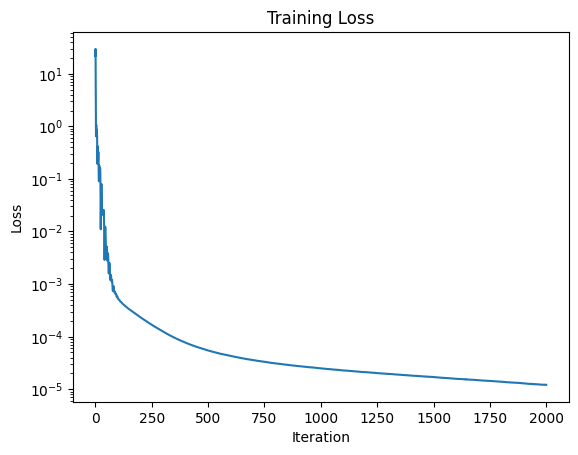

Relative L1 error: 0.9989914130227241
Relative L2 error: 0.9987978198437939


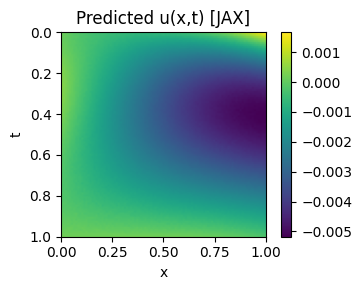

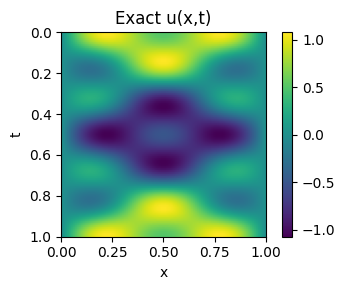

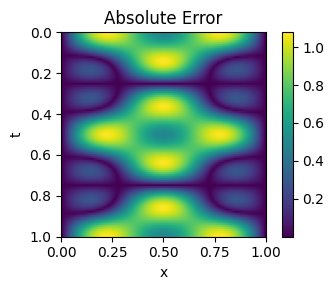

In [3]:

# JAX implementation of PINNsFormer for 1D Wave Equation
# Based on the paper: "PINNsFormer: A Transformer-Based Framework For Physics-Informed Neural Networks"
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap, value_and_grad
from flax import linen as nn
import optax
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm, trange

dense_kernel_init = nn.initializers.xavier_uniform()
dense_bias_init = nn.initializers.constant(0.01)

# Custom activation function with learnable parameters (Wavelet Activation)
class WaveAct(nn.Module):
    @nn.compact
    def __call__(self, x):
        w1 = self.param('w1', nn.initializers.constant(1.0), (1,))
        w2 = self.param('w2', nn.initializers.constant(1.0), (1,))
        return w1 * jnp.sin(x) + w2 * jnp.cos(x)


# Define the TanH activation class
class TanH(nn.Module):
    @nn.compact
    def __call__(self, x):
        return jnp.tanh(x)

# FeedForward network used in Transformer layers
class FeedForward(nn.Module):
    d_model: int
    d_ff: int = 256
    activation: Callable[[], nn.Module] = WaveAct  # Default activation

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.d_ff, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(x)
        x = self.activation()(x)
        x = nn.Dense(self.d_ff, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(x)
        x = self.activation()(x)
        x = nn.Dense(self.d_model, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(x)
        return x

class EncoderLayer(nn.Module):
    d_model: int
    num_heads: int
    activation: Callable[[], nn.Module] = WaveAct  # Default activation

    @nn.compact
    def __call__(self, x):
        # Apply first activation
        x2 = self.activation()(x)
        
        # Self-Attention: query, key, value all come from x2
        attn_output = nn.MultiHeadDotProductAttention(
            num_heads=self.num_heads,
            qkv_features=self.d_model,
            use_bias=True,
            dropout_rate=0.0,
            deterministic=False
        )(x2)
        
        # Residual connection
        x = x + attn_output
        
        # Apply second activation
        x2 = self.activation()(x)
        
        # Feedforward network
        ff_output = FeedForward(d_model=self.d_model, activation=self.activation) (x2)
        
        # Residual connection
        x = x + ff_output
        
        return x

class DecoderLayer(nn.Module):
    d_model: int
    num_heads: int
    activation: Callable[[], nn.Module] = WaveAct  # Default activation

    @nn.compact
    def __call__(self, x, e_outputs):
        # Apply first activation
        x2 = self.activation()(x)
        
        # Cross-Attention: query from decoder, key & value from encoder
        cross_attn = nn.MultiHeadDotProductAttention(
            num_heads=self.num_heads,
            qkv_features=self.d_model,
            use_bias=True,
            dropout_rate=0.0,
            deterministic=False
        )
        attn_output = cross_attn(x2, e_outputs)
        
        # Residual connection
        x = x + attn_output
        
        # Apply second activation
        x2 = self.activation()(x)
        
        # Feedforward network
        ff_output = FeedForward(d_model=self.d_model, activation=self.activation)(x2)
        
        # Residual connection
        x = x + ff_output
        
        return x

# Encoder consisting of multiple encoder layers
class Encoder(nn.Module):
    d_model: int
    N: int  # Number of layers
    num_heads: int
    activation: Callable[[], nn.Module] = WaveAct  # Default activation

    @nn.compact
    def __call__(self, x):
        for _ in range(self.N):
            x = EncoderLayer(self.d_model, self.num_heads, self.activation)(x)
        x = self.activation()(x)
        return x

# Decoder consisting of multiple decoder layers
class Decoder(nn.Module):
    d_model: int
    N: int  # Number of layers
    num_heads: int
    activation: Callable[[], nn.Module] = WaveAct  # Default activation

    @nn.compact
    def __call__(self, x, e_outputs):
        for _ in range(self.N):
            x = DecoderLayer(self.d_model, self.num_heads, self.activation)(x, e_outputs)
        x = self.activation()(x)
        return x

# PINNsFormer model combining the encoder and decoder
class PINNsformer(nn.Module):
    d_out: int
    d_hidden: int
    d_model: int
    N: int  # Number of encoder/decoder layers
    num_heads: int
    activation: Callable[[], nn.Module] = WaveAct  # Default activation

    @nn.compact
    def __call__(self, x_seq, t_seq):
        # x_seq and t_seq have shape (batch_size, seq_len, 1)
        src = jnp.concatenate([x_seq, t_seq], axis=-1)  # Shape: (batch_size, seq_len, 2)
        src = nn.Dense(self.d_model, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(src)  # Spatio-temporal mixer
        e_outputs = Encoder(self.d_model, self.N, self.num_heads, self.activation)(src)
        d_output = Decoder(self.d_model, self.N, self.num_heads, self.activation)(src, e_outputs)
        x = nn.Dense(self.d_hidden, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(d_output)
        x = self.activation()(x)
        x = nn.Dense(self.d_hidden, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(x)
        x = self.activation()(x)
        x = nn.Dense(self.d_out, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(x)  # Output layer
        return x  # Shape: (batch_size, seq_len, d_out)



# Function to count the number of parameters in the model
def get_n_params(params):
    return sum([np.prod(p.shape) for p in jax.tree_util.tree_leaves(params)])


# Function to generate training and boundary data
def get_data(x_range, y_range, x_num, y_num):
    x = np.linspace(x_range[0], x_range[1], x_num)
    t = np.linspace(y_range[0], y_range[1], y_num)
    x_mesh, t_mesh = np.meshgrid(x, t)
    data = np.stack([x_mesh.flatten(), t_mesh.flatten()], axis=-1)

    b_left = data[np.isclose(x_mesh.flatten(), x_range[0])]
    b_right = data[np.isclose(x_mesh.flatten(), x_range[1])]
    b_upper = data[np.isclose(t_mesh.flatten(), y_range[1])]
    b_lower = data[np.isclose(t_mesh.flatten(), y_range[0])]

    return data, b_left, b_right, b_upper, b_lower

# Function to create time sequences for inputs
def make_time_sequence(src, num_step=5, step=1e-4):
    # src shape: (N, 2)
    N = src.shape[0]
    seq = np.tile(src[:, None, :], (1, num_step, 1))  # (N, seq_len, 2)
    for i in range(num_step):
        seq[:, i, -1] += step * i
    return seq  # Shape: (N, seq_len, 2)

def print_model_io_shapes(model, x_seq, t_seq):
    """
    Prints the shapes of the inputs (x_seq, t_seq) and 
    the final output of the model.
    """
    print(f"Input x_seq shape: {x_seq.shape}")
    print(f"Input t_seq shape: {t_seq.shape}")
    
    # Initialize the model with dummy/random parameters
    dummy_key = random.PRNGKey(42)
    variables = model.init(dummy_key, x_seq, t_seq)
    
    # Forward pass to get the output
    output = model.apply(variables, x_seq, t_seq)
    
    print(f"Output shape: {output.shape}")



# Generate training data
res, b_left, b_right, b_upper, b_lower = get_data([0, 1], [0, 1], 51, 51)
res_test, _, _, _, _ = get_data([0, 1], [0, 1], 101, 101)

# Create pseudo sequences
num_step = 5
delta_t = 1e-4
res_seq = make_time_sequence(res, num_step=num_step, step=delta_t)
b_left_seq = make_time_sequence(b_left, num_step=num_step, step=delta_t)
b_right_seq = make_time_sequence(b_right, num_step=num_step, step=delta_t)
b_upper_seq = make_time_sequence(b_upper, num_step=num_step, step=delta_t)
b_lower_seq = make_time_sequence(b_lower, num_step=num_step, step=delta_t)

# Convert data to JAX arrays
res_seq = jnp.array(res_seq)
b_left_seq = jnp.array(b_left_seq)
b_right_seq = jnp.array(b_right_seq)
b_upper_seq = jnp.array(b_upper_seq)
b_lower_seq = jnp.array(b_lower_seq)

# Extract x and t sequences
x_res_seq, t_res_seq = res_seq[:, :, 0:1], res_seq[:, :, 1:2]
x_left_seq, t_left_seq = b_left_seq[:, :, 0:1], b_left_seq[:, :, 1:2]
x_right_seq, t_right_seq = b_right_seq[:, :, 0:1], b_right_seq[:, :, 1:2]
x_upper_seq, t_upper_seq = b_upper_seq[:, :, 0:1], b_upper_seq[:, :, 1:2]
x_lower_seq, t_lower_seq = b_lower_seq[:, :, 0:1], b_lower_seq[:, :, 1:2]

# For initialization, we can use a subset of the data
init_x = x_res_seq[:64]  # Shape: (64, seq_len, 1)
init_t = t_res_seq[:64]  # Shape: (64, seq_len, 1)


# Initialize model and optimizer
key = random.PRNGKey(0)
model = PINNsformer(
    d_out=1,
    d_hidden=32,
    d_model=32,
    N=1,
    num_heads=2,
    activation=TanH # You can replace WaveAct with any other activation module
)

print_model_io_shapes(model, init_x, init_t)


variables = model.init(key, init_x, init_t)

# Use Adam optimizer
learning_rate = 1e-3
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(variables)

n_params = get_n_params(variables)
print(f"Number of parameters: {n_params}")

pi = jnp.pi

def loss_fn(params, x_res_seq, t_res_seq, x_left_seq, t_left_seq, x_right_seq, t_right_seq, x_upper_seq, t_upper_seq, x_lower_seq, t_lower_seq):
    # Compute u_seq over residual points
    u_seq = model.apply(params, x_res_seq, t_res_seq)
    
    # Compute u_tt_seq and u_xx_seq
    u_tt_seq = compute_u_tt(params, x_res_seq, t_res_seq)
    u_xx_seq = compute_u_xx(params, x_res_seq, t_res_seq)
    
    # Compute residual loss over all time steps
    residual = u_tt_seq - 4 * u_xx_seq  # Shape: (batch_size, seq_len, 1)
    loss_res = jnp.mean(residual ** 2)
    
    # Boundary conditions over sequences
    pred_upper_seq = model.apply(params, x_upper_seq, t_upper_seq)
    pred_lower_seq = model.apply(params, x_lower_seq, t_lower_seq)
    loss_bc = jnp.mean(pred_upper_seq ** 2) + jnp.mean(pred_lower_seq ** 2)
    
    # Initial conditions (only first time step)
    x_left = x_left_seq[:, 0, :]  # Shape: (batch_size, 1)
    t_left = t_left_seq[:, 0, :]  # Should be t=0
    pred_left = model.apply(params, x_left_seq[:, 0:1, :], t_left_seq[:, 0:1, :]).squeeze()  # Shape: (batch_size,)
    # Compute initial condition u(x,0)
    x_left_flat = x_left.squeeze()
    initial_condition = jnp.sin(pi * x_left_flat) + 0.5 * jnp.sin(3 * pi * x_left_flat)
    loss_ic_1 = jnp.mean((pred_left - initial_condition) ** 2)
    
    # Compute du/dt at t=0
    def u_fn_scalar(x, t):
        x = x.reshape(1, 1, 1)
        t = t.reshape(1, 1, 1)
        u = model.apply(params, x, t)
        return u.squeeze()
    
    ui_t = vmap(lambda x, t: grad(u_fn_scalar, argnums=1)(x, t))(x_left_flat, t_left.squeeze())
    loss_ic_2 = jnp.mean(ui_t ** 2)
    loss_ic = loss_ic_1 + loss_ic_2
    
    # Total loss
    loss = loss_res + loss_ic + loss_bc

    # Prepare auxiliary outputs and stop gradients
    # aux = (jax.lax.stop_gradient(loss_res), jax.lax.stop_gradient(loss_ic), jax.lax.stop_gradient(loss_bc))
    aux = (loss_res, loss_ic, loss_bc)
    
    return loss, aux



# Functions to compute second-order derivatives
def compute_u_tt(params, x_seq, t_seq):
    x_seq_flat = x_seq.reshape(-1, 1)
    t_seq_flat = t_seq.reshape(-1, 1)
    
    def u_fn_scalar(x, t):
        x = x.reshape(1, 1, 1)
        t = t.reshape(1, 1, 1)
        u = model.apply(params, x, t)
        return u.squeeze()
    
    def u_t_fn(x, t):
        return grad(u_fn_scalar, argnums=1)(x, t)
    
    def u_tt_fn(x, t):
        return grad(u_t_fn, argnums=1)(x, t)
    
    u_tt_flat = vmap(u_tt_fn)(x_seq_flat.squeeze(), t_seq_flat.squeeze())
    u_tt_seq = u_tt_flat.reshape(x_seq.shape)
    return u_tt_seq

def compute_u_xx(params, x_seq, t_seq):
    x_seq_flat = x_seq.reshape(-1, 1)
    t_seq_flat = t_seq.reshape(-1, 1)
    
    def u_fn_scalar(x, t):
        x = x.reshape(1, 1, 1)
        t = t.reshape(1, 1, 1)
        u = model.apply(params, x, t)
        return u.squeeze()
    
    def u_x_fn(x, t):
        return grad(u_fn_scalar, argnums=0)(x, t)
    
    def u_xx_fn(x, t):
        return grad(u_x_fn, argnums=0)(x, t)
    
    u_xx_flat = vmap(u_xx_fn)(x_seq_flat.squeeze(), t_seq_flat.squeeze())
    u_xx_seq = u_xx_flat.reshape(x_seq.shape)
    return u_xx_seq

# Create a function to compute the loss and gradients
@jit
def train_step(params, opt_state, x_res_seq, t_res_seq, x_left_seq, t_left_seq, x_right_seq, t_right_seq, x_upper_seq, t_upper_seq, x_lower_seq, t_lower_seq):
    (loss_value, aux), grads = value_and_grad(loss_fn, has_aux=True)(
        params, x_res_seq, t_res_seq, x_left_seq, t_left_seq,
        x_right_seq, t_right_seq, x_upper_seq, t_upper_seq, x_lower_seq, t_lower_seq
    )
    loss_res, loss_ic, loss_bc = aux
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value, loss_res, loss_ic, loss_bc

def print_tabulate(self,
                    exmp_input : Any):
    """
    Prints a summary of the Module represented as table.

    Args:
        exmp_input: An input to the model with which the shapes are inferred.
    """
    print(self.model.tabulate(random.PRNGKey(0), *exmp_input, train=True))


# Training loop
loss_track = []
params = variables

from tqdm import trange

num_epochs = 2000
pbar = trange(num_epochs)
best_params = None
best_loss = float('inf')
for i in pbar:
    params, opt_state, loss_value, loss_res, loss_ic, loss_bc = train_step(
        params, opt_state, x_res_seq, t_res_seq, x_left_seq, t_left_seq,
        x_right_seq, t_right_seq, x_upper_seq, t_upper_seq, x_lower_seq, t_lower_seq
    )
    if loss_value < best_loss:
        best_loss = loss_value
        best_params = params


    loss_track.append(loss_value)

    if i % 100 == 0:
        pbar.set_postfix({'Loss': float(loss_value), 'Res': float(loss_res), 'IC': float(loss_ic), 'BC': float(loss_bc)})


print(f"Final Loss: {loss_track[-1]}")
print(f"Best Loss: {best_loss}")



plt.plot(loss_track)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Save the trained model parameters
import pickle
with open('1dwave_pinnsformer_params.pkl', 'wb') as f:
    pickle.dump(best_params, f)



import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Suppose we have 'model' defined in Flax and 'params' loaded or trained.

def get_data_jx(x_range, y_range, x_num, y_num):
    """
    JAX-style function that:
      - Creates a mesh over [x_range[0], x_range[1]] x [y_range[0], y_range[1]]
      - Flattens into 'data'
      - Extracts boundaries by np.isclose() to x=0, x=1, t=0, t=1
    Returns: (res, b_left, b_right, b_upper, b_lower) as NumPy arrays
    """
    x = np.linspace(x_range[0], x_range[1], x_num)
    t = np.linspace(y_range[0], y_range[1], y_num)
    x_mesh, t_mesh = np.meshgrid(x, t)  # shape: (y_num, x_num)

    data = np.stack([x_mesh.flatten(), t_mesh.flatten()], axis=-1)  # shape: (y_num*x_num, 2)

    # "res" is all interior points
    res = data

    b_left  = data[np.isclose(x_mesh.flatten(), x_range[0])]
    b_right = data[np.isclose(x_mesh.flatten(), x_range[1])]
    b_upper = data[np.isclose(t_mesh.flatten(), y_range[1])]
    b_lower = data[np.isclose(t_mesh.flatten(), y_range[0])]

    return res, b_left, b_right, b_upper, b_lower


def make_time_sequence_jx(src, num_step=1, step=0.0):
    """
    Same logic as before, but defaulting to 1 time step and no time increment.
    """
    N = src.shape[0]  # (N,2)
    seq = np.tile(src[:, None, :], (1, num_step, 1))  # (N,1,2)
    for i in range(num_step):
        seq[:, i, -1] += step * i
    return seq

# Analytical solution
def u_ana(x, t):
    return np.sin(np.pi*x) * np.cos(2*np.pi*t) + 0.5 * np.sin(3*np.pi*x) * np.cos(6*np.pi*t)

# 1) Generate test data
res_test, _, _, _, _ = get_data_jx([0,1], [0,1], 101, 101)
# shape (101*101, 2)

# 2) Single time step
res_test_1step = make_time_sequence_jx(res_test, num_step=1, step=0.0)
# shape: (101*101, 1, 2)

res_test_1step = jnp.array(res_test_1step)

# 3) Split x and t
x_test_seq = res_test_1step[:, :, 0:1]  # shape (N,1,1)
t_test_seq = res_test_1step[:, :, 1:2]  # shape (N,1,1)
N = x_test_seq.shape[0]  # 101*101

# load best params into model
with open('1dwave_pinnsformer_params.pkl', 'rb') as f:
    best_params = pickle.load(f)

# 4) Predict in batches or all at once
def predict(params, x_seq, t_seq):
    return model.apply(params, x_seq, t_seq)

batch_size = 1000
pred_list = []
for start in range(0, N, batch_size):
    x_batch = x_test_seq[start:start+batch_size]
    t_batch = t_test_seq[start:start+batch_size]
    # model.apply(...) => shape (batch_size, 1, 1) if d_out=1
    pred_batch = predict(best_params, x_batch, t_batch).squeeze(axis=-1)  # => shape (batch_size, 1)
    pred_list.append(np.array(pred_batch))

pred = np.concatenate(pred_list, axis=0)  # shape (N, 1) => or (N,)
pred = pred.reshape(101, 101)

# 5) Exact solution
xvals = res_test[:, 0]  # (N,)
tvals = res_test[:, 1]  # (N,)
u_exact = u_ana(xvals, tvals).reshape(101, 101)

# 6) Relative errors
rl1 = np.sum(np.abs(u_exact - pred)) / np.sum(np.abs(u_exact))
rl2 = np.sqrt(np.sum((u_exact - pred)**2) / np.sum(u_exact**2))
print("Relative L1 error:", rl1)
print("Relative L2 error:", rl2)

# 7) Plots
plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,1,1,0], cmap='viridis')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t) [JAX]')
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure(figsize=(4,3))
plt.imshow(u_exact, extent=[0,1,1,0], cmap='viridis')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure(figsize=(4,3))
plt.imshow(np.abs(pred - u_exact), extent=[0,1,1,0], cmap='viridis')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.show()



## MAMBA-PINN

### inspect shapes and training dynamics

### Training Loop

Model Summary (MambaWavePINN):
params/Dense_0/kernel: shape=(2, 64), size=128
params/Dense_0/bias: shape=(64,), size=64
params/ResidualBlock_0/MambaBlock_0/Dense_0/kernel: shape=(64, 256), size=16384
params/ResidualBlock_0/MambaBlock_0/Conv_0/kernel: shape=(4, 1, 128), size=512
params/ResidualBlock_0/MambaBlock_0/Conv_0/bias: shape=(128,), size=128
params/ResidualBlock_0/MambaBlock_0/Dense_1/kernel: shape=(128, 4100), size=524800
params/ResidualBlock_0/MambaBlock_0/Dense_2/kernel: shape=(4, 128), size=512
params/ResidualBlock_0/MambaBlock_0/Dense_2/bias: shape=(128,), size=128
params/ResidualBlock_0/MambaBlock_0/A_log: shape=(128, 16), size=2048
params/ResidualBlock_0/MambaBlock_0/D: shape=(128,), size=128
params/ResidualBlock_0/MambaBlock_0/Dense_3/kernel: shape=(128, 64), size=8192
params/ResidualBlock_1/MambaBlock_0/Dense_0/kernel: shape=(64, 256), size=16384
params/ResidualBlock_1/MambaBlock_0/Conv_0/kernel: shape=(4, 1, 128), size=512
params/ResidualBlock_1/MambaBlock_0/Conv_0/bia

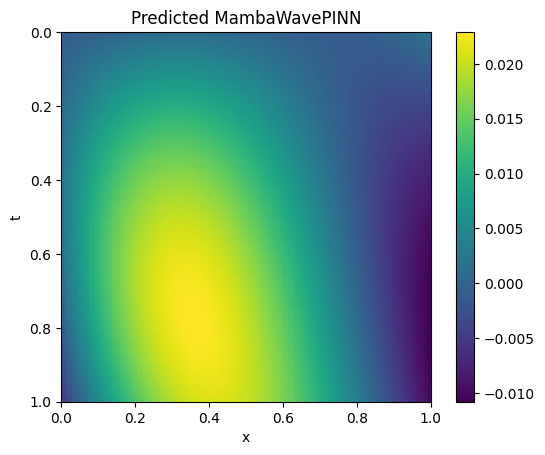

Model Summary (MambaWavePINN):
params/Dense_0/kernel: shape=(2, 64), size=128
params/Dense_0/bias: shape=(64,), size=64
params/ResidualBlock_0/MambaBlock_0/Dense_0/kernel: shape=(64, 256), size=16384
params/ResidualBlock_0/MambaBlock_0/Conv_0/kernel: shape=(4, 1, 128), size=512
params/ResidualBlock_0/MambaBlock_0/Conv_0/bias: shape=(128,), size=128
params/ResidualBlock_0/MambaBlock_0/Dense_1/kernel: shape=(128, 4100), size=524800
params/ResidualBlock_0/MambaBlock_0/Dense_2/kernel: shape=(4, 128), size=512
params/ResidualBlock_0/MambaBlock_0/Dense_2/bias: shape=(128,), size=128
params/ResidualBlock_0/MambaBlock_0/A_log: shape=(128, 16), size=2048
params/ResidualBlock_0/MambaBlock_0/D: shape=(128,), size=128
params/ResidualBlock_0/MambaBlock_0/Dense_3/kernel: shape=(128, 64), size=8192
params/ResidualBlock_1/MambaBlock_0/Dense_0/kernel: shape=(64, 256), size=16384
params/ResidualBlock_1/MambaBlock_0/Conv_0/kernel: shape=(4, 1, 128), size=512
params/ResidualBlock_1/MambaBlock_0/Conv_0/bia

In [1]:
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit
import optax
from flax import linen as nn
from flax.traverse_util import flatten_dict
from dataclasses import dataclass
from typing import Union
import math
import numpy as np
from functools import partial
from tqdm import trange
import matplotlib.pyplot as plt
import pickle

dense_kernel_init = nn.initializers.xavier_uniform()
dense_bias_init = nn.initializers.constant(0.01)

# -------------------------------------------------------------------------
# 1) MODEL ARGUMENTS
# -------------------------------------------------------------------------
@dataclass
class ModelArgs:
    d_model: int = 64        # Hidden dimension
    n_layer: int = 2         # Number of layers
    d_state: int = 16        # Latent state dimension
    expand: int = 2          # Expansion factor
    dt_rank: Union[int, str] = 'auto'  # Rank of Δ
    d_conv: int = 4          # Convolution kernel size
    conv_bias: bool = True
    bias: bool = False

    def __post_init__(self):
        self.d_inner = int(self.expand * self.d_model)
        if self.dt_rank == 'auto':
            self.dt_rank = math.ceil(self.d_model / 16)

# -------------------------------------------------------------------------
# 2) NORM, BLOCKS, and MAMBA MODEL (unchanged from your code)
# -------------------------------------------------------------------------
class RMSNorm(nn.Module):
    d_model: int
    eps: float = 1e-5

    @nn.compact
    def __call__(self, x):
        # rms = jnp.sqrt(jnp.mean(jnp.square(x), axis=-1, keepdims=True) + self.eps)
        # scale = self.param('scale', nn.initializers.ones, (self.d_model,))
        # return x / rms * scale
        return x

class MambaBlock(nn.Module):
    args: ModelArgs

    @nn.compact
    def __call__(self, x):
        args = self.args
        d_model = args.d_model
        d_inner = args.d_inner
        d_state = args.d_state
        dt_rank = args.dt_rank

        # Input Projection
        x_and_res = nn.Dense(features=d_inner * 2, use_bias=args.bias, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(x)
        x_proj, res = jnp.split(x_and_res, 2, axis=-1)

        # Depthwise Convolution
        x_conv = x_proj
        x_conv = nn.Conv(
            features=d_inner,
            kernel_size=(args.d_conv,),
            feature_group_count=d_inner,
            padding='SAME',
            use_bias=args.conv_bias
        )(x_conv)
        x = nn.gelu(x_conv)

        # Compute delta, B, C
        x_dbl = nn.Dense(features=dt_rank + 2 * d_state * d_inner, use_bias=args.bias, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(x)
        delta, B_C = jnp.split(x_dbl, [dt_rank], axis=-1)
        b, l, _ = delta.shape

        B_C = B_C.reshape(b, l, d_inner, 2*d_state)
        B, C = jnp.split(B_C, 2, axis=-1)  # => shapes (b,l,d_inner,d_state)

        delta = nn.softplus(nn.Dense(features=d_inner, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(delta))  # => (b,l,d_inner)

        # State Space Params
        A_log = self.param('A_log', nn.initializers.normal(), (d_inner, d_state))
        D = self.param('D', nn.initializers.ones, (d_inner,))
        A = -jnp.exp(A_log)

        y = self.ssm(x, delta, A, B, C, D)
        y = y * nn.gelu(res)
        output = nn.Dense(features=d_model, use_bias=args.bias, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(y)
        return output

    def ssm(self, x, delta, A, B, C, D):
        b, l, d = x.shape
        n = A.shape[1]

        # Discretize A
        deltaA = jnp.exp(jnp.einsum('bld,dn->bldn', delta, A))
        deltaB_u = jnp.einsum('bld,bldn,bld->bldn', delta, B, x)

        x_state = jnp.zeros((b, d, n))

        def scan_fn(carry, inputs):
            x_prev = carry
            deltaA_t, deltaB_u_t = inputs
            x_t = deltaA_t * x_prev + deltaB_u_t
            return x_t, x_t

        deltaA_list = deltaA.transpose(1, 0, 2, 3)   # => (l,b,d,n)
        deltaB_u_list = deltaB_u.transpose(1, 0, 2, 3)
        _, x_states = jax.lax.scan(scan_fn, x_state, (deltaA_list, deltaB_u_list))
        x_states = x_states.transpose(1,0,2,3)  # => (b,l,d,n)

        y = jnp.einsum('bldn,bldn->bld', x_states, C)
        y = y + x * D[None, None, :]
        return y

class ResidualBlock(nn.Module):
    args: ModelArgs

    @nn.compact
    def __call__(self, x):
        norm = RMSNorm(self.args.d_model)
        x_norm = norm(x)
        mixer = MambaBlock(self.args)
        y = mixer(x_norm)
        return x + y

class Mamba(nn.Module):
    args: ModelArgs

    @nn.compact
    def __call__(self, x):
        # x: (batch_size, seq_len, input_dim)
        x = nn.Dense(features=self.args.d_model)(x)
        for _ in range(self.args.n_layer):
            x = ResidualBlock(self.args)(x)
        x = RMSNorm(self.args.d_model)(x)
        logits = nn.Dense(features=1, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(x)
        return logits  # => (batch_size, seq_len, 1)

# -------------------------------------------------------------------------
# 3) MambaWavePINN Class for 1D Wave Equation
# -------------------------------------------------------------------------
class MambaWavePINN:
    """
    PINN using the Mamba architecture for the 1D wave equation:
      u_tt - 4 u_xx = 0,
    with typical:
      u(x,0) = sin(pi x) - 0.5 sin(3 pi x),
      u_t(x,0) = 0,
    and boundary conditions:
      u(0,t)=0, u(1,t)=0.
    """
    def __init__(
        self,
        key,
        args: ModelArgs,
        x_seq_res: jnp.ndarray,
        t_seq_res: jnp.ndarray,
        x_seq_ic: jnp.ndarray,
        t_seq_ic: jnp.ndarray,
        x_seq_bc: jnp.ndarray,
        t_seq_bc: jnp.ndarray,
        learning_rate=1e-3,
    ):
        self.model = Mamba(args)
        self.key = key
        # Initialize params with dummy input => shape (1, 5, 2)
        dummy_input = jnp.ones((1, 5, 2))
        self.params = self.model.init(self.key, dummy_input)

        # Store data
        self.x_seq_res = x_seq_res
        self.t_seq_res = t_seq_res
        self.x_seq_ic  = x_seq_ic
        self.t_seq_ic  = t_seq_ic
        self.x_seq_bc  = x_seq_bc
        self.t_seq_bc  = t_seq_bc

        self.optimizer = optax.adam(learning_rate)
        self.opt_state = self.optimizer.init(self.params)

        # Logs
        self.loss_log = []
        self.loss_ic_log = []
        self.loss_bc_log = []
        self.loss_res_log = []

        self.print_model_summary()

    def neural_net(self, params, t_seq, x_seq):
        """ Evaluate Mamba model on (t_seq, x_seq) => (batch_size, seq_len, 1). """
        tx_inputs = jnp.concatenate([t_seq, x_seq], axis=-1)  # => (B,L,2)
        u_pred = self.model.apply(params, tx_inputs)          # => (B,L,1)
        return u_pred
    


    def residual_net(self, params, t_seq, x_seq):
        """ PDE residual for wave eqn: u_tt - 4u_xx = 0. """
        t_flat = t_seq.reshape(-1)
        x_flat = x_seq.reshape(-1)

        def u_fn(t, x):
            # Returns a single scalar
            inp = jnp.array([[[t, x]]])  # shape (1,1,2)
            out = self.model.apply(params, inp)  # shape (1,1,1)
            return out[0,0,0]

        def u_t_scalar(t, x):
            # 1st derivative wrt t
            return grad(u_fn, argnums=0)(t, x)  # => scalar

        def u_tt_scalar(t, x):
            # 2nd derivative wrt t
            return grad(lambda T: u_t_scalar(T, x))(t)

        def u_x_scalar(t, x):
            # 1st derivative wrt x
            return grad(u_fn, argnums=1)(t, x)

        def u_xx_scalar(t, x):
            # 2nd derivative wrt x
            return grad(lambda X: u_x_scalar(t, X))(x)

        # Vectorize the scalar second derivatives
        vmap_u_tt = vmap(u_tt_scalar, in_axes=(0, 0))
        vmap_u_xx = vmap(u_xx_scalar, in_axes=(0, 0))

        u_tt_vals = vmap_u_tt(t_flat, x_flat)
        u_xx_vals = vmap_u_xx(t_flat, x_flat)

        # PDE: u_tt - 4 u_xx = 0
        r_vals = u_tt_vals - 4.0*u_xx_vals
        return r_vals.reshape(t_seq.shape)

    @partial(jit, static_argnums=0)
    def loss_fn(self, params):
        # 1) PDE residual
        r_vals = self.residual_net(params, self.t_seq_res, self.x_seq_res)
        loss_res = jnp.mean(r_vals**2)

        # 2) Initial condition
        u_ic_pred = self.neural_net(params, self.t_seq_ic, self.x_seq_ic)  # => (B,L,1)
        x_ic_flat = self.x_seq_ic.reshape(-1)
        # u(x,0) = sin(pi x) - 0.5 sin(3 pi x)
        u_ic_true = jnp.sin(jnp.pi*x_ic_flat) - 0.5*jnp.sin(3.0*jnp.pi*x_ic_flat)
        u_ic_true = u_ic_true.reshape(u_ic_pred.shape[0], u_ic_pred.shape[1])  # => (B,L)
        loss_ic_1 = jnp.mean((u_ic_pred.squeeze(-1) - u_ic_true)**2)

        # Also enforce partial u/partial t = 0 at t=0
        def scalar_u(t, x):
            inp = jnp.array([[[t,x]]])
            return self.model.apply(params, inp)[0,0,0]

        u_t0 = vmap(lambda xx: grad(scalar_u, argnums=0)(0.0, xx))(x_ic_flat)
        loss_ic_2 = jnp.mean(u_t0**2)
        loss_ic = loss_ic_1 + loss_ic_2

        # 3) Boundary condition => u=0 at x=0 or x=1
        u_bc_pred = self.neural_net(params, self.t_seq_bc, self.x_seq_bc)  # => shape (B,L,1)
        loss_bc = jnp.mean(u_bc_pred**2)

        loss_total = loss_res + loss_ic + loss_bc
        return loss_total, (loss_res, loss_ic, loss_bc)

    @partial(jit, static_argnums=0)
    def update_step(self, params, opt_state):
        (loss_val, (loss_res, loss_ic, loss_bc)), grads = jax.value_and_grad(self.loss_fn, has_aux=True)(params)
        updates, opt_state = self.optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_val, loss_res, loss_ic, loss_bc

    def train(self, n_iter=5000, print_every=100):
        params = self.params
        opt_state = self.opt_state
        for i in range(n_iter):
            params, opt_state, loss_val, l_res, l_ic, l_bc = self.update_step(params, opt_state)
            if i % print_every == 0:
                self.loss_log.append(float(loss_val))
                self.loss_res_log.append(float(l_res))
                self.loss_ic_log.append(float(l_ic))
                self.loss_bc_log.append(float(l_bc))
                print(f"[Iter {i}] Loss={loss_val:.3e} Res={l_res:.3e} IC={l_ic:.3e} BC={l_bc:.3e}")
        self.params = params
        self.opt_state = opt_state

    def predict(self, t_seq, x_seq):
        """ Evaluate model in batch => shape (N, seq_len, 1). """
        return self.neural_net(self.params, t_seq, x_seq)

    def print_model_summary(self):
        flat_params = flatten_dict(self.params)
        total_params = 0
        print("Model Summary (MambaWavePINN):")
        for path, param in flat_params.items():
            print(f"{'/'.join(path)}: shape={param.shape}, size={param.size}")
            total_params += param.size
        print(f"Total parameters: {total_params}")

def make_time_sequence(src, num_step=5, step=1e-4):
    """
    For each row of src (which is (t, x)), replicate across seq_len=num_step
    and increment t by 'step * i'.
    => shape: (N, num_step, 2)
    """
    N = src.shape[0]
    seq = np.tile(src[:, None, :], (1, num_step, 1))
    for i in range(num_step):
        seq[:, i, 0] += step*i  # increment the t-component
    return seq

# Function to generate training and boundary data
def get_data(x_range, y_range, x_num, y_num):
    x = np.linspace(x_range[0], x_range[1], x_num)
    t = np.linspace(y_range[0], y_range[1], y_num)
    x_mesh, t_mesh = np.meshgrid(x, t)
    data = np.stack([x_mesh.flatten(), t_mesh.flatten()], axis=-1)

    b_left = data[np.isclose(x_mesh.flatten(), x_range[0])]
    b_right = data[np.isclose(x_mesh.flatten(), x_range[1])]
    b_upper = data[np.isclose(t_mesh.flatten(), y_range[1])]
    b_lower = data[np.isclose(t_mesh.flatten(), y_range[0])]

    return data, b_left, b_right, b_upper, b_lower


# A small helper that returns the wave PDE data in the same style:
def get_data_wave_1d(x_range, t_range, x_num, t_num):
    res, b_left, b_right, b_upper, b_lower = get_data(x_range, t_range, x_num, t_num)
    return res, b_left, b_right, b_upper, b_lower

# (b) Functions to save and load the MambaWavePINN
def save_mamba_wave_pinn(pinn, file_name='mamba_wave_pinn.pkl'):
    """
    Save the MambaWavePINN's parameters and ModelArgs to a file.
    """
    data = {
        'params': pinn.params,
        'args': pinn.model.args,  # or pinn.args if you store them separately
    }
    with open(file_name, 'wb') as f:
        pickle.dump(data, f)
    print(f"Saved MambaWavePINN to '{file_name}'")

def load_mamba_wave_pinn(file_name,
                         x_seq_res, t_seq_res,
                         x_seq_ic, t_seq_ic,
                         x_seq_bc, t_seq_bc,
                         learning_rate=1e-3):
    """
    Load the saved parameters and ModelArgs from file, then instantiate a MambaWavePINN.
    You must provide x_seq_res, t_seq_res, x_seq_ic, etc. for initialization
    (they can be dummy placeholders of the same shape as the original training data).
    Returns the loaded MambaWavePINN with its parameters set.
    """
    with open(file_name, 'rb') as f:
        data = pickle.load(f)
    loaded_params = data['params']
    loaded_args   = data['args']

    dummy_key = jax.random.PRNGKey(0)
    # Create a MambaWavePINN with the same hyperparameters but dummy data
    pinn = MambaWavePINN(
        key=dummy_key,
        args=loaded_args,
        x_seq_res=x_seq_res, t_seq_res=t_seq_res,
        x_seq_ic=x_seq_ic,   t_seq_ic=t_seq_ic,
        x_seq_bc=x_seq_bc,   t_seq_bc=t_seq_bc,
        learning_rate=learning_rate
    )
    # Overwrite with loaded params
    pinn.params = loaded_params
    print(f"Loaded MambaWavePINN from '{file_name}'")
    return pinn

# (c) A small helper to get the exact wave solution
def wave_exact_solution(x, t):
    """
    Example wave eqn solution:
      u(x,t) = sin(pi*x)*cos(2*pi*t) + 0.5*sin(3*pi*x)*cos(6*pi*t)
    """
    return np.sin(np.pi*x)*np.cos(2.0*np.pi*t) + 0.5*np.sin(3.0*np.pi*x)*np.cos(6.0*np.pi*t)


# -------------------------------------------------------------------------
# (2) Main Usage Example
# -------------------------------------------------------------------------

# 1) Create a random PRNG key + define model hyperparameters
key = jax.random.PRNGKey(0)
# args = ModelArgs(d_model=16, n_layer=2, d_state=16, expand=4, dt_rank='auto')
args = ModelArgs()

# 2) Generate interior & boundary data for the wave eqn
res, b_left, b_right, b_upper, b_lower = get_data_wave_1d([0,1],[0,1], 51,51)
# res has shape (2601, 2) => each row: (t, x)

# 3) Turn them into sequences for PDE, IC, BC
#    PDE residual points
res_seq = make_time_sequence(res, num_step=5, step=1e-4)  # => shape (2601,5,2)
res_seq_jnp = jnp.array(res_seq)
t_seq_res = res_seq_jnp[:,:,0:1]  # (2601,5,1)
x_seq_res = res_seq_jnp[:,:,1:2]  # (2601,5,1)

#    Initial condition: t=0 => b_lower
b_lower_seq = make_time_sequence(b_lower, num_step=1, step=0.0)
b_lower_seq_jnp = jnp.array(b_lower_seq)
t_seq_ic = b_lower_seq_jnp[:,:,0:1]  # => (N_ic,1,1)
x_seq_ic = b_lower_seq_jnp[:,:,1:2]

#    Boundary condition: x=0 or x=1 => combine b_left & b_right
b_bc = np.concatenate([b_left, b_right], axis=0)
b_bc_seq = make_time_sequence(b_bc, num_step=5, step=1e-4)
b_bc_seq_jnp = jnp.array(b_bc_seq)
t_seq_bc = b_bc_seq_jnp[:,:,0:1]
x_seq_bc = b_bc_seq_jnp[:,:,1:2]

# 4) Initialize the model
pinn = MambaWavePINN(
    key=key,
    args=args,
    x_seq_res=x_seq_res, t_seq_res=t_seq_res,
    x_seq_ic=x_seq_ic,   t_seq_ic=t_seq_ic,
    x_seq_bc=x_seq_bc,   t_seq_bc=t_seq_bc,
    learning_rate=1e-3
)

# 5) Train
pinn.train(n_iter=1000, print_every=200)

# 6) Save the trained model
save_mamba_wave_pinn(pinn, file_name='mamba_wave_pinn.pkl')

# 7) Evaluate or do additional predictions

#    For demonstration, let's do it *directly* with this 'pinn'.
#    Optionally, you could re-load from disk to prove that it works.

#    Suppose we want to evaluate on a finer (101 x 101) grid
res_test, _, _, _, _ = get_data_wave_1d([0,1],[0,1], 101, 101)
# shape => (101*101, 2) => each row: (t, x)

# Make a single-step sequence => (N,1,2)
res_test_seq = make_time_sequence(res_test, num_step=1, step=0.0)
res_test_seq_jnp = jnp.array(res_test_seq)
t_test = res_test_seq_jnp[:,:,0:1]  # => (N,1,1)
x_test = res_test_seq_jnp[:,:,1:2]

# Predict
u_pred = pinn.predict(t_test, x_test)  # => shape (N,1,1)
# Reshape => (101,101)
u_pred_np = np.array(u_pred.squeeze(-1)).reshape(101,101)

# Compare with exact solution
# Note: our 'res_test' is (t,x).
tvals = res_test[:,0]
xvals = res_test[:,1]
u_exact = wave_exact_solution(xvals, tvals).reshape(101,101)

# L1, L2 error
rl1 = np.sum(np.abs(u_exact - u_pred_np)) / np.sum(np.abs(u_exact))
rl2 = np.sqrt( np.sum((u_exact - u_pred_np)**2) / np.sum(u_exact**2) )
print("\nFinal relative L1 error:", rl1)
print("Final relative L2 error:", rl2)

# Quick plot
plt.figure()
plt.imshow(u_pred_np, extent=[0,1,1,0], cmap='viridis')
plt.title("Predicted MambaWavePINN")
plt.xlabel("x"); plt.ylabel("t"); plt.colorbar()
plt.show()

# 8) (Optional) Now let's load from disk and do the same predictions
#    - We pass dummy data for PDE, IC, BC shapes that match the original
#    - Then re-run predict

# For example, create the same shape placeholders:
dummy_x_seq_res = jnp.zeros_like(x_seq_res)
dummy_t_seq_res = jnp.zeros_like(t_seq_res)
dummy_x_seq_ic  = jnp.zeros_like(x_seq_ic)
dummy_t_seq_ic  = jnp.zeros_like(t_seq_ic)
dummy_x_seq_bc  = jnp.zeros_like(x_seq_bc)
dummy_t_seq_bc  = jnp.zeros_like(t_seq_bc)

pinn_loaded = load_mamba_wave_pinn(
    file_name='mamba_wave_pinn.pkl',
    x_seq_res=dummy_x_seq_res, t_seq_res=dummy_t_seq_res,
    x_seq_ic=dummy_x_seq_ic,   t_seq_ic=dummy_t_seq_ic,
    x_seq_bc=dummy_x_seq_bc,   t_seq_bc=dummy_t_seq_bc,
    learning_rate=1e-3
)

# Predict again
pred_loaded = pinn_loaded.predict(t_test, x_test)
pred_loaded_np = np.array(pred_loaded.squeeze(-1)).reshape(101,101)
diff = np.max(np.abs(pred_loaded_np - u_pred_np))
print(f"Max difference between loaded and original model predictions: {diff:e}")
print("Done!")

### Sine Gordon STDE PINNsFormer